In [ ]:


# Research: Steps
# 

In [2]:
import json
import numpy as np
import pandas as pd
import datetime as dt
from pandas.io.json import json_normalize
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)



In [3]:
with open('data0928/control_user_types.json') as json_file:
    control_user_types_data = json.load(json_file)

In [4]:
with open('data0928/forecasts.json') as json_file_2:
    fcast_data = json.load(json_file_2)
fcast_data_ifp = pd.read_csv('data0928/fcasts0928_with_ifp_turk_info.csv')


/Users/vnkn/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
fcast_data_ifp = fcast_data_ifp[fcast_data_ifp['team_id'] >= 0]

In [1]:
# Processing the forecasts and generate preds, wager, conf and mse matrix
ifps = pd.read_csv("data0928/ifps0928_refined.csv")
ifps = ifps.set_index('id')
MAX_NUM_OF_OUTCOME = 5
def generate_daily_pred_matrix(fcast_data, ifps, start_date):
    user_map = {}
    user_type_vector = []
    j = 0
    for i in fcast_data['user_id'].unique():
        user_map[i] = j
        team_id = fcast_data[fcast_data['user_id'] == i]['team_id'].iloc[0]
        if team_id == 1000: user_type_vector.append(3) # control group
        elif team_id < 100: user_type_vector.append(1) # volunteer
        else: user_type_vector.append(2) # turkers
        j += 1
    user_type_vector = np.array(user_type_vector)
    user_id_vector = fcast_data['user_id'].unique()
    m = len(user_map)
    n = len(ifps)
    print("matrix shape: ", n, m)
    
    #date = dt.datetime.strptime(fcast_data['created_at'].iloc[0][:10], "%Y-%m-%d").date()
    date = start_date
    print(date)
    indicator = np.zeros((n,m), dtype=int)
    #pred_matrix = -1 * np.ones((n,m), dtype=object)
    pred_matrix = -1 * np.ones((n,m, MAX_NUM_OF_OUTCOME))
    conf_matrix = -1 * np.ones((n,m))
    wager_matrix = -1 * np.ones((n,m))
    se_matrix = -1 * np.ones((n,m))
    preds_age_matrix = -1 * np.ones((n,m))
    open_ifps = np.zeros(n, dtype=int)
    
    daily_indicator = []
    daily_pred_matrix = []
    daily_conf_matrix = []
    daily_wager_matrix = []
    daily_se_matrix = []
    daily_open_vector = []
    daily_preds_age = []

    for idx, row in fcast_data.iterrows():
        while (row['timestamp'][:10]!=str(date)):  
            for qid, ifp in ifps.iterrows():
                map_id = ifp["map_id"]
                #print(qid, map_id)
                if str(date) >= ifp['ifp_opens_at'] and str(date) <= ifp['ifp_closes_at']:
                    open_ifps[map_id] += 1 # if an IFP is open, open_status open days so far
                elif str(date) >= ifp['ifp_resolves_at']:
                    open_ifps[map_id] = -2 # if an IFP is resolved, open_status=-2
                elif str(date) >= ifp['ifp_closes_at']:
                    open_ifps[map_id] = -1 # if an IFP is closed but not resolved, open_status=-1 
            #print(open_ifps)
            daily_indicator.append(np.array(indicator))
            daily_open_vector.append(np.array(open_ifps))
            daily_pred_matrix.append(np.array(pred_matrix))
            daily_conf_matrix.append(np.array(conf_matrix))
            daily_wager_matrix.append(np.array(wager_matrix))
            daily_se_matrix.append(np.array(se_matrix))
            daily_preds_age.append(np.array(preds_age_matrix))
            date += dt.timedelta(1)
            preds_age_matrix[preds_age_matrix>-0.1] += 1
            print(date)
            

        i = ifps.loc[row['question_id'], 'map_id']
        j = user_map[row['user_id']]
        indicator[i, j] = 1
        preds_age_matrix[i, j] = 0
        
        prediction = []
        ans_in_str = row['forecast']
        pos = ans_in_str.find("'value':")
        while pos >= 0:
            prediction.append(float(ans_in_str[pos+8: ans_in_str.find(',', pos)]))
            pos = ans_in_str.find("'value':", pos+1)
        if len(prediction)==1:
            prediction.append(100-prediction[0])
        prediction = np.array(prediction) / 100
        pred_matrix[i, j, :] = 0.0
        pred_matrix[i, j, :len(prediction)] = prediction

        conf_matrix[i, j] = row['confidence']
        wager_matrix[i, j] = row['wager']

        if np.isnan(row['ground_truth']): se_matrix[i, j] = -1
        else:
            true_label = int(row['ground_truth']-1)
            se_matrix[i, j] = np.sum(prediction**2) - prediction[true_label]**2 + (1-prediction[true_label])**2
    
    for qid, ifp in ifps.iterrows():
        map_id = ifp["map_id"]
        if str(date) >= ifp['ifp_opens_at'] and str(date) <= ifp['ifp_closes_at']:
            open_ifps[map_id] += 1 # if an IFP is open, open_status open days so far
        elif str(date) >= ifp['ifp_resolves_at']:
            open_ifps[map_id] = -2 # if an IFP is resolved, open_status=-2
        elif str(date) >= ifp['ifp_closes_at']:
            open_ifps[map_id] = -1 # if an IFP is closed but not resolved, open_status=-1 
    daily_indicator.append(np.array(indicator))
    daily_open_vector.append(np.array(open_ifps))
    daily_pred_matrix.append(np.array(pred_matrix))
    daily_conf_matrix.append(np.array(conf_matrix))
    daily_wager_matrix.append(np.array(wager_matrix))
    daily_se_matrix.append(np.array(se_matrix))
    daily_preds_age.append(np.array(preds_age_matrix))
    
    return (daily_indicator, daily_pred_matrix, daily_conf_matrix, daily_wager_matrix, daily_se_matrix,
            daily_open_vector, user_type_vector, user_id_vector, daily_preds_age)

daily_indicator, daily_pred_matrix, daily_conf_matrix, daily_wager_matrix, daily_se_matrix, daily_open_vector, user_type_vector, user_id_vector, daily_preds_age\
= generate_daily_pred_matrix(fcast_data_ifp, ifps, dt.date(2018,3,7))

print(len(daily_pred_matrix))
print(daily_pred_matrix[0].shape)
#print(daily_pred_matrix[0])

NameError: name 'pd' is not defined

In [10]:
#print(fcast_data.keys())
print(len(fcast_data))#, len(ifp_data))
fcast_data = fcast_data['predictions'] #'predictions' is the only first tier key of the json file
print(len(fcast_data))#, len(ifp_data))
fcasts = json_normalize(fcast_data)
fcasts = fcasts.sort_values(by=['question_id','user_id','created_at'], ascending=[True, True, True])
fcasts = fcasts.reset_index()

fcasts.columns


1
347992


Index(['index', 'auto', 'confidence', 'created_at', 'downvotes', 'forecast',
       'question_id', 'rationale', 'team_id', 'upvotes', 'user_id', 'wager'],
      dtype='object')

In [11]:
len(fcast_data_ifp)
len(fcasts)

347992

In [12]:
fcast_data_ifp['forecast'] = fcasts['forecast']

In [200]:
#fcast_data_ifp = pd.read_csv('data0928/fcasts0928_with_ifp_turk_info.csv')

/Users/vnkn/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
fcasts[:10]

index auto  confidence                  created_at downvotes  \
0  270788  NaN          50  2018-03-07T21:14:22.570000       NaN   
1  270803  NaN          50  2018-03-08T11:32:04.229000       NaN   
2  270818  NaN          50  2018-03-08T11:36:27.071000       NaN   
3  270833  NaN          50  2018-03-08T12:06:56.276000       NaN   
4  270850  NaN          50  2018-03-08T17:16:10.279000       NaN   
5  270871  NaN          50  2018-03-08T17:29:26.831000       NaN   
6  270892  NaN          50  2018-03-08T18:59:21.981000       NaN   
7  270913  NaN          50  2018-03-12T10:40:33.661000       NaN   
8  270933  NaN          50  2018-03-13T11:47:58.605000       NaN   
9  270953  NaN          50  2018-03-15T15:18:16.954000       NaN   

                                            forecast  question_id rationale  \
0  [{'value': 99.9992291186786, 'answer_id': 2481...          822             
1  [{'value': 99.99793903047009, 'answer_id': 248...          822             
2  [{'value': 99.9999412941342, 'answer_id': 2481...          822             
3  [{'value': 99.9999993070015, 'answer_id': 2481...          822             
4  [{'value': 20.0, 'answer_id': 2481}, {'value':...          822             
5  [{'value': 20.0, 'answer_id': 2481}, {'value':...          822             
6  [{'value': 20.0, 'answer_id': 2481}, {'value':...          822             
7  [{'value': 20.0, 'answer_id': 2481}, {'value':...          822             
8  [{'value': 20.0, 'answer_id': 2481}, {'value':...          822             
9  [{'value': 20.0, 'answer_id': 2481}, {'value':...          822             

   team_id upvotes  user_id  wager  
0       -1     NaN      -11      0  
1       -1     NaN      -11      0  
2       -1     NaN      -11      0  
3       -1     NaN      -11      0  
4       -1     NaN      -11      0  
5       -1     NaN      -11      0  
6       -1     NaN      -11      0  
7       -1     NaN      -11      0  
8       -1     NaN      -11      0  
9       -1     NaN      -11      0

In [17]:
fcast_data_ifp[:2]

Unnamed: 0  Unnamed: 0.1 auto  confidence                  created_at  \
0           0        270788  NaN          50  2018-03-07T21:14:22.570000   
1           1        270803  NaN          50  2018-03-08T11:32:04.229000   

  downvotes                                           forecast  question_id  \
0       NaN  [{'value': 99.9992291186786, 'answer_id': 2481...          822   
1       NaN  [{'value': 99.99793903047009, 'answer_id': 248...          822   

  rationale  team_id upvotes  user_id  wager                   timestamp  \
0       NaN       -1     NaN      -11      0  2018-03-07T21:14:22.570000   
1       NaN       -1     NaN      -11      0  2018-03-08T11:32:04.229000   

   turk_user   id  resolved?  type  ground_truth  \
0      False  822       True     5           1.0   
1      False  822       True     5           1.0   

                                             answers ifp_opens_at  \
0  [{'ended?': True, 'probability': 1.0, 'questio...   2018-03-07   
1  [{'ended?': True, 'probability': 1.0, 'questio...   2018-03-07   

  ifp_closes_at ifp_resolves_at  
0    2018-04-30      2018-05-08  
1    2018-04-30      2018-05-08

In [201]:
fcast_data_ifp

Unnamed: 0  Unnamed: 0.1  auto  confidence  \
0                0        270788   NaN          50   
1                1        270803   NaN          50   
2                2        270818   NaN          50   
3                3        270833   NaN          50   
4                4        270850   NaN          50   
5                5        270871   NaN          50   
6                6        270892   NaN          50   
7                7        270913   NaN          50   
8                8        270933   NaN          50   
9                9        270953   NaN          50   
10              10        270983   NaN          50   
11              11        271019   NaN          50   
12              12        271287   NaN          50   
13              13        271317   NaN          50   
14              14        271389   NaN          50   
15              15        271426   NaN          50   
16              16        271457   NaN          50   
17              17        271580   NaN          50   
18              18        271613   NaN          50   
19              19        271646   NaN          50   
20              20        271679   NaN          50   
21              21        271877   NaN          50   
22              22        271935   NaN          50   
23              23        271975   NaN          50   
24              24        272004   NaN          50   
25              25        272242   NaN          50   
26              26        272267   NaN          50   
27              27        272288   NaN          50   
28              28        272311   NaN          50   
29              29        272334   NaN          50   
30              30        272376   NaN          50   
31              31        272443   NaN          50   
32              32        272543   NaN          50   
33              33        272804   NaN          50   
34              34        270787   NaN          50   
35              35        270802   NaN          50   
36              36        270817   NaN          50   
37              37        270832   NaN          50   
38              38        270849   NaN          50   
39              39        270870   NaN          50   
40              40        270891   NaN          50   
41              41        270912   NaN          50   
42              42        270932   NaN          50   
43              43        270952   NaN          50   
44              44        270982   NaN          50   
45              45        271018   NaN          50   
46              46        271286   NaN          50   
47              47        271316   NaN          50   
48              48        271388   NaN          50   
49              49        271425   NaN          50   
50              50        271456   NaN          50   
51              51        271579   NaN          50   
52              52        271612   NaN          50   
53              53        271645   NaN          50   
54              54        271678   NaN          50   
55              55        271876   NaN          50   
56              56        271934   NaN          50   
57              57        271974   NaN          50   
58              58        272003   NaN          50   
59              59        272241   NaN          50   
60              60        272266   NaN          50   
61              61        272287   NaN          50   
62              62        272310   NaN          50   
63              63        272333   NaN          50   
64              64        272375   NaN          50   
65              65        272442   NaN          50   
66              66        272542   NaN          50   
67              67        272803   NaN          50   
68              68        247777   NaN          60   
69              69        247778   NaN          60   
70              70        247779   NaN          60   
71              71        247780   NaN          60   
72              72        247781   NaN          60   
73          

In [164]:
#fcasts['forecast'][0]
#fcast_data_ifp['forecast'][0]

[{'answer_id': 6250, 'name': 'Yes', 'value': 16.0}]

In [ ]:
# Figure out Discrepancy between FCAST_Data, Forecasts datasets

In [153]:
fcast_data_ifp['forecast'] = fcasts['forecast']

In [13]:
fcasts['forecast'][:10]
fcasts[:2]

index auto  confidence                  created_at downvotes  \
0  270788  NaN          50  2018-03-07T21:14:22.570000       NaN   
1  270803  NaN          50  2018-03-08T11:32:04.229000       NaN   

                                            forecast  question_id rationale  \
0  [{'value': 99.9992291186786, 'answer_id': 2481...          822             
1  [{'value': 99.99793903047009, 'answer_id': 248...          822             

   team_id upvotes  user_id  wager  
0       -1     NaN      -11      0  
1       -1     NaN      -11      0

In [14]:
fcast_data_ifp

Unnamed: 0  Unnamed: 0.1  auto  confidence  \
0                0        270788   NaN          50   
1                1        270803   NaN          50   
2                2        270818   NaN          50   
3                3        270833   NaN          50   
4                4        270850   NaN          50   
5                5        270871   NaN          50   
6                6        270892   NaN          50   
7                7        270913   NaN          50   
8                8        270933   NaN          50   
9                9        270953   NaN          50   
10              10        270983   NaN          50   
11              11        271019   NaN          50   
12              12        271287   NaN          50   
13              13        271317   NaN          50   
14              14        271389   NaN          50   
15              15        271426   NaN          50   
16              16        271457   NaN          50   
17              17        271580   NaN          50   
18              18        271613   NaN          50   
19              19        271646   NaN          50   
20              20        271679   NaN          50   
21              21        271877   NaN          50   
22              22        271935   NaN          50   
23              23        271975   NaN          50   
24              24        272004   NaN          50   
25              25        272242   NaN          50   
26              26        272267   NaN          50   
27              27        272288   NaN          50   
28              28        272311   NaN          50   
29              29        272334   NaN          50   
30              30        272376   NaN          50   
31              31        272443   NaN          50   
32              32        272543   NaN          50   
33              33        272804   NaN          50   
34              34        270787   NaN          50   
35              35        270802   NaN          50   
36              36        270817   NaN          50   
37              37        270832   NaN          50   
38              38        270849   NaN          50   
39              39        270870   NaN          50   
40              40        270891   NaN          50   
41              41        270912   NaN          50   
42              42        270932   NaN          50   
43              43        270952   NaN          50   
44              44        270982   NaN          50   
45              45        271018   NaN          50   
46              46        271286   NaN          50   
47              47        271316   NaN          50   
48              48        271388   NaN          50   
49              49        271425   NaN          50   
50              50        271456   NaN          50   
51              51        271579   NaN          50   
52              52        271612   NaN          50   
53              53        271645   NaN          50   
54              54        271678   NaN          50   
55              55        271876   NaN          50   
56              56        271934   NaN          50   
57              57        271974   NaN          50   
58              58        272003   NaN          50   
59              59        272241   NaN          50   
60              60        272266   NaN          50   
61              61        272287   NaN          50   
62              62        272310   NaN          50   
63              63        272333   NaN          50   
64              64        272375   NaN          50   
65              65        272442   NaN          50   
66              66        272542   NaN          50   
67              67        272803   NaN          50   
68              68        247777   NaN          60   
69              69        247778   NaN          60   
70              70        247779   NaN          60   
71              71        247780   NaN          60   
72              72        247781   NaN          60   
73          

In [15]:
fcasts['forecast'][50]

[{'answer_id': 2481, 'value': 100.0},
 {'answer_id': 2482, 'value': 0.0},
 {'answer_id': 2483, 'value': 0.0},
 {'answer_id': 2484, 'value': 0.0},
 {'answer_id': 2485, 'value': 1.59068179144836e-164}]

In [16]:
fcasts['forecast'][50]

[{'answer_id': 2481, 'value': 100.0},
 {'answer_id': 2482, 'value': 0.0},
 {'answer_id': 2483, 'value': 0.0},
 {'answer_id': 2484, 'value': 0.0},
 {'answer_id': 2485, 'value': 1.59068179144836e-164}]

In [17]:
fcast_data_ifp['forecast'][0]

[{'answer_id': 2481, 'value': 99.9992291186786},
 {'answer_id': 2482, 'value': 0.0007682365296120681},
 {'answer_id': 2483, 'value': 2.63270598295677e-06},
 {'answer_id': 2484, 'value': 1.20811481452555e-08},
 {'answer_id': 2485, 'value': 4.63754612433109e-12}]

In [18]:
fcast_data_ifp_mod[:2]

NameError: name 'fcast_data_ifp_mod' is not defined

In [40]:
len(fcast_data_ifp)

347992

In [7]:
#print(control_user_types_data.keys())#, ifp_data.keys())

In [29]:
control_users = fcasts[fcasts['user_id'] > 9000]

In [19]:
ifp_control_users = fcast_data_ifp[fcast_data_ifp['user_id'] > 9000]

In [23]:
control_user_ids_list = []
for row in ifp_control_users['user_id']:
    print(row)
    control_user_ids_list.append(control_user_types_data[str(row)])

9001
9003
9003
9007
9007
9013
9013
9013
9013
9013
9014
9014
9014
9016
9017
9017
9017
9017
9017
9017
9017
9020
9028
9030
9030
9030
9030
9030
9032
9032
9034
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9039
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9043
9045
9046
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9059
9065
9068
9078
9090
9090
9090
9090
9093
9097
9099
9118
9118
9141
9156
9161
9265
9267
9268
9268
9270
9272
9284
9295
9298
9300
9302
9314
9357
9364
9366
9368
9371
9397
9398
9413
9413
9416
9425
9426
9433
9455
9456
9463
9480
9001
9005
9013
9013
9013
9013
9014
9014
9014
9014
9014
9016
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9020
9028
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9032
9034
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9039
9039
9039
9039
9039
9039
9039
9039
9039
9041
9041
9041
9041


9213
9214
9216
9218
9219
9222
9225
9228
9235
9239
9246
9247
9249
9250
9252
9257
9260
9265
9267
9269
9270
9272
9284
9295
9298
9300
9301
9302
9303
9310
9312
9314
9318
9326
9328
9329
9330
9331
9334
9335
9339
9339
9341
9344
9346
9346
9349
9349
9349
9359
9360
9361
9363
9364
9369
9371
9372
9375
9375
9375
9375
9376
9377
9379
9379
9381
9384
9384
9385
9388
9388
9388
9389
9393
9399
9401
9406
9406
9406
9406
9412
9417
9419
9426
9433
9472
9480
9526
9529
9530
9534
9540
9548
9549
9550
9551
9552
9553
9556
9557
9558
9561
9564
9565
9567
9568
9569
9575
9580
9586
9589
9592
9593
9594
9605
9609
9612
9617
9621
9625
9629
9631
9648
9651
9657
9658
9660
9661
9663
9665
9674
9677
9689
9692
9695
9696
9697
9703
9710
9712
9714
9719
9722
9727
9728
9729
9736
9757
9760
9761
9762
9763
9764
9769
9773
9775
9778
9784
9787
9798
9799
9800
9801
9804
9810
9811
9816
9818
9822
9827
9836
9846
9850
9857
9857
9859
9860
9863
9863
9865
9870
9874
9877
9878
9885
9893
9895
9897
9901
9909
9918
9928
9933
9934
9942
9943
9945
9947
9962
9964


9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9053
9061
9068
9072
9072
9074
9082
9089
9099
9107
9129
9130
9146
9146
9146
9151
9151
9160
9160
9161
9177
9179
9195
9265
9267
9268
9268
9269
9272
9275
9284
9295
9298
9300
9302
9306
9314
9325
9332
9338
9339
9341
9359
9364
9371
9371
9375
9397
9398
9413
9413
9413
9418
9426
9427
9432
9433
9446
9447
9449
9455
9456
9463
9466
9473
9473
9500
9513
9513
9513
9513
9001
9002
9004
9004
9004
9004
9004
9007
9007
9013
9014
9014
9016
9017
9017
9020
9020
9028
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9032
9037
9037
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041


9762
9763
9766
9767
9771
9774
9775
9778
9779
9780
9783
9783
9784
9785
9786
9791
9794
9795
9797
9798
9799
9801
9802
9803
9804
9807
9808
9810
9812
9814
9815
9820
9821
9823
9824
9825
9826
9830
9832
9833
9836
9837
9840
9841
9843
9845
9846
9847
9848
9851
9852
9856
9860
9862
9864
9867
9871
9872
9873
9874
9876
9879
9880
9882
9884
9887
9889
9890
9892
9893
9897
9898
9901
9907
9909
9911
9912
9913
9917
9919
9920
9921
9924
9926
9927
9928
9931
9933
9934
9936
9937
9938
9939
9941
9944
9947
9948
9949
9950
9952
9954
9955
9957
9957
9959
9960
9963
9965
9966
9967
9968
9969
9972
9983
9984
9993
9997
10002
10024
10024
10026
10029
10034
10042
10050
10051
10052
10053
10058
10061
10062
10070
10071
10074
10075
10075
10077
10080
10081
10085
10089
10091
10094
10095
10106
10131
10131
10136
10137
10146
10151
10162
10167
9001
9005
9007
9008
9008
9008
9011
9013
9013
9013
9014
9014
9014
9014
9014
9014
9015
9015
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9020
9028
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030

9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9032
9034
9037
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9039
9039
9039
9039
9039
9039
9039
9039
9039
9039
9039
9039
9040
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9042
9043
9045
9046
9046
9046
9046
9046
9046
9046
9046
9047
9047
9047
9047
9047
9047
9047
9048
9051
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052


9051
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9064
9065
9068
9078
9082
9089
9092
9093
9095
9095
9096
9097
9141
9173
9175
9180
9183
9185
9191
9194
9198
9203
9204
9206
9207
9208
9209
9211
9216
9217
9218
9221
9222
9223
9224
9226
9228
9230
9237
9247
9248
9249
9250
9251
9255
9256
9259
9262
9263
9265
9272
9284
9288
9298
9300
9302
9314
9339
9341
9344
9381
9449
9457
9457
9459
9470
9473
9474
9475
9480
9482
9484
9495
9516
9519
9523
9527
9529
9531
9531
9533
9535
9538
9546
9547
9549
9554
9558
9559
9560
9561
9563
9564
9566
9567
9568
9570
9572
9576
9576
9582
9584
9585
9587
9588
9590
9594
9595
9600
9603
9604
9605
9606
9618
9620
9622
9623
9631
9632
9633
9636
9642
9646
9647
9650
9651
9652
9658
9659
9663
9664
9666
9671
9674
9679
9681
9684
9686
9688
9689
9690
9691
9692
9697
9698
9700
9702
9704
9705
9706
9707
9709
9712
9714
9715
9718
9718
9720
9721
9724
9725
9728
9729
9732
9732
9736


9980
9980
9992
9995
9996
9997
10002
10018
10029
10048
10049
10059
10067
10070
10094
10095
9001
9002
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9006
9006
9006
9008
9008
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9013
9013
9013
9013
9013
9013
9013
9014
9014
9017
9017
9017
9020
9024
9024
9028
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9042
9042
9042
9042
9042
9042
9043
9044
9044
9044
9044
9044


9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9043
9044
9044
9045
9046
9046
9046
9046
9046
9046
9046
9047
9047
9047
9047
9050
9051
9052
9053
9059
9063
9063
9064
9065
9066
9066
9068
9078
9084
9087
9093
9093
9100
9102
9109
9112
9112
9122
9122
9122
9122
9141
9142
9143
9152
9155
9156
9160
9165
9172
9173
9176
9176
9176
9177
9177
9177
9179
9180
9183
9186
9190
9198
9200
9209
9217
9218
9244
9245
9247
9251
9256
9259
9261
9265
9272
9276
9292
9298
9320
9325
9330
9341
9421
9457
9480
9509
9510
9514
9516
9516
9518
9519
9529
9530
9535
9541
9543
9546
9556
9565
9566
9569
9571
9575
9576
9576
9577
9579
9582
9599
9600
9602
9606
9607
9608
9631
9637
9645
9651
9660
9668
9678
9683
9685
9686
9701
9703
9707
9708
9713
9715
9718
9722
9726
9734
9736
9737
9752
9759
9764
9774
9781
9783
9790
9791
9802
9803
9810
9818
9820
9825
9826
9827
9829
9838
9844
9859
9860
9862
9873
9878
9884
9891
9906
9909
9920
9927
9933
9935
9943
9949
9953
9955
9956
9967
9969
9971
9986
9987
10002
10006
10047
10065
10113
9001


9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9044
9044
9044
9045
9052
9052
9052
9060
9065
9077
9093
9093
9097
9190
9196
9202
9204
9213
9219
9228
9240
9247
9257
9265
9284
9298
9548
9555
9563
9580
9632
9658
9678
9709
9712
9728
9748
9777
9778
9788
9799
9813
9825
9827
9857
9863
9925
9936
9945
9956
9001
9002
9003
9004
9005
9006
9007
9008
9008
9009
9013
9013
9013
9013
9013
9014
9016
9017
9019
9020
9022
9023
9024
9025
9029
9029
9029
9029
9029
9030
9031
9031
9032
9032
9032
9032
9035
9037
9037
9037
9038
9038
9038
9038
9038
9038
9038
9039
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9042
9042
9043
9044
9045
9046
9046
9046
9047
9048
9049
9050
9051
9051
9052
9053
9054
9060
9061
9062
9063
9065
9066
9068
9073
9074
9075
9076
9078
9078
9079
9080
9082
9085
9086
9087
9088
9089
9090
9092
9093
9095
9096
9099
9100
9100
9103
9104
9105
9105
9107
9110
9112
9113
9115
9116
9118
9125
9127
9128


9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9043
9043
9044
9045
9046
9048
9050
9052
9052
9052
9052
9052
9052
9060
9060
9060
9060
9060
9060
9060
9060
9060
9060
9064
9065
9066
9066
9066
9066
9066
9068
9078
9079
9083
9093
9102
9106
9124
9127
9135
9141
9142
9143
9146
9152
9184
9188
9192
9194
9196
9201
9203
9204
9206
9207
9208
9209
9210
9211
9214
9215
9216
9217
9218
9219
9220
9222
9223
9224
9225
9226
9227
9228
9229
9232
9242
9244
9245
9247
9248
9249
9250
9251
9253
9255
9256
9258
9259
9262
9263
9264
9265
9339
9341
9363
9520
9521
9523
9525
9527
9529
9530
9531
9533
9534
9535
9536
9537
9538
9542
9545
9546
9547
9554
9556
9558
9560
9561
9565
9566
9567
9568
9569
9570
9571
9572
9574
9575
9576
9577
9578
9581
9584
9585
9586
9587
9589
9590
9591
9592
9593
9594
9598
9599
9600
9601


9839
9840
9841
9843
9845
9847
9851
9852
9853
9855
9856
9859
9860
9862
9864
9866
9867
9870
9871
9873
9876
9877
9878
9879
9880
9882
9884
9887
9891
9892
9894
9895
9896
9900
9901
9903
9906
9912
9918
9919
9921
9922
9923
9924
9926
9927
9928
9930
9931
9932
9933
9934
9936
9937
9938
9939
9943
9944
9945
9946
9947
9948
9949
9951
9953
9954
9955
9957
9959
9960
9963
9965
9966
9967
9972
9981
9982
9983
9984
9985
9987
9989
9994
9997
10000
10002
10002
10026
10027
10029
10031
10034
10045
10047
10054
10061
10063
10071
10075
10077
10078
10086
10087
10092
10096
10104
10106
10131
10147
10149
10155
9001
9003
9013
9014
9016
9017
9020
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9036
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
904

9052
9052
9052
9052
9052
9052
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9065
9093
9093
9097
9141
9162
9162
9162
9166
9166
9178
9189
9190
9192
9194
9196
9199
9200
9201
9202
9203
9204
9206
9212
9214
9215
9218
9222
9225
9227
9228
9230
9239
9243
9244
9245
9247
9248
9250
9255
9257
9258
9261
9265
9284
9298
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9320
9325
9341
9349
9349
9438
9522
9529
9530
9532
9534
9536
9538
9548
9549
9550
9552
9553
9556
9557
9558
9558
9563
9563
9564
9565
9567
9568
9570
9572
9574
9575
9579
9580
9581
9586
9588
9589
9590
9597
9602
9608
9611
9612
9617
9619
9620
9622
9623
9625
9627
9629
9631
9632
9640
9643
9655
9658
9660
9663
9665
9667
9670
9672
9674
9681
9686
9687
9689
9692
9695
9696
9698
9701
9702
9704
9706
9710
9712
9719
9721
9722
9726
9727
9728
9732
9739
9741
9741
9744
9749
9756
9757
9758
9761
9765
9770
9771
9775
9778
9779
9782
9783
9784
9788
9790
9791
9793
9796
9801


9592
9595
9598
9599
9603
9605
9608
9618
9622
9625
9627
9629
9631
9633
9635
9637
9641
9645
9646
9647
9650
9660
9661
9667
9674
9678
9679
9683
9685
9686
9688
9690
9693
9694
9698
9700
9701
9705
9707
9713
9715
9718
9724
9731
9732
9736
9737
9739
9751
9752
9753
9759
9763
9764
9767
9770
9772
9774
9776
9778
9780
9781
9782
9785
9786
9787
9789
9790
9793
9795
9797
9798
9802
9804
9806
9806
9811
9813
9815
9818
9823
9827
9829
9834
9837
9838
9842
9843
9849
9850
9851
9852
9857
9859
9862
9866
9867
9870
9871
9879
9880
9883
9884
9887
9890
9891
9892
9893
9896
9898
9901
9907
9911
9911
9920
9922
9924
9926
9927
9930
9931
9932
9937
9938
9943
9948
9949
9951
9956
9957
9960
9962
9963
9967
9969
9971
9983
9989
9997
10002
10029
10047
10048
10050
10062
10065
10074
10075
10076
10096
10102
10106
10131
9001
9017
9017
9017
9020
9027
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9039
9039
9039
9039
9039
9039
9039
9039
9039
9039
9

9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9044
9044
9046
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9060
9060
9063
9063
9063
9065
9093
9093
9097
9141
9147
9163
9163
9180
9180
9186
9187
9188
9192
9196
9198
9202
9204
9205
9206
9208
9209
9210
9211
9215
9217
9218
9219
9222
9224
9227
9228
9230
9235
9239
9245
9247
9250
9251
9253
9255
9257
9258
9261
9265
9298
9325
9339
9339
9339
9361
9522
9526
9526
9527
9529
9530
9531
9532
9534
9536
9537
9538
9543
9544
9549
9552
9553
9554
9558
9561
9562
9563
9565
9567
9568
9569
9572
9574
9577
9578
9579
9580
9581
9582
9586
9589
9590
9591
9592
9595
9597
9599
9600
9601
9607
9608
9608
9609
9611
9612
9613
9616
9617
9618
9618
9619
9621
9623
9625
9627
9628
9629
9631
9637
9638
9639
9640
9643
9649
9650
9654
9656
9658
9661
9662
9663
9664
9665
9675
9675
9678
9680
9681
9682
9685
9695
9696
9697
9702
9704
9707
9708
9712
9719
9720
9722
9727


9416
9478
9478
9497
9501
9505
9514
9521
9523
9528
9539
9541
9542
9545
9555
9556
9562
9590
9594
9600
9607
9610
9613
9615
9631
9642
9645
9656
9662
9677
9681
9684
9688
9713
9718
9732
9741
9754
9758
9763
9771
9774
9779
9785
9788
9796
9823
9827
9856
9857
9865
9876
9878
9893
9899
9913
9917
9924
9926
9931
9936
9951
9954
9960
9964
9966
9978
9984
9987
9990
9992
9993
10001
10002
10004
10005
10008
10009
10012
10013
10014
10015
10018
10019
10020
9001
9013
9030
9030
9033
9033
9033
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9044
9044
9052
9052
9052
9052
9052
9059
9065
9093
9141
9145
9176
9176
9184
9185
9186
9190
9191
9200
9206
9208
9214
9219
9221
9229
9237
9246
9249
9252
9260
9265
9298
9456
9521
9524
9527
9551
9555
9557
9558
9559
9560
9561
9562
9564
9566
9567
9569
9579
9581
9584
9585
9589
9593
9603
9611
9620
9622
9632
9633
9637
9639
9645
9646
9656
9661
9664
9666
9673
9682
9683
9685
9688
9692
9701
9705
9707
9709
9720
9724
97

9633
9635
9636
9637
9638
9639
9640
9642
9645
9646
9649
9650
9652
9653
9654
9656
9657
9658
9659
9660
9661
9664
9666
9667
9669
9670
9674
9675
9678
9679
9679
9680
9681
9682
9684
9685
9686
9688
9689
9690
9691
9693
9696
9697
9698
9700
9701
9702
9704
9705
9706
9707
9708
9709
9710
9711
9712
9714
9715
9718
9718
9720
9720
9722
9723
9724
9727
9728
9729
9730
9730
9732
9733
9734
9735
9737
9739
9742
9743
9744
9746
9747
9748
9751
9752
9753
9754
9755
9756
9757
9758
9759
9761
9762
9764
9765
9767
9768
9769
9770
9771
9773
9774
9775
9776
9779
9781
9784
9786
9787
9788
9789
9790
9793
9795
9796
9797
9799
9800
9801
9802
9803
9804
9805
9806
9807
9809
9811
9812
9813
9814
9815
9816
9818
9820
9821
9822
9823
9824
9825
9826
9829
9830
9833
9834
9836
9837
9838
9839
9841
9842
9843
9845
9846
9847
9848
9850
9851
9852
9853
9856
9860
9862
9863
9864
9866
9867
9870
9871
9873
9875
9876
9877
9878
9879
9880
9883
9884
9885
9887
9892
9893
9894
9895
9896
9898
9900
9901
9902
9903
9907
9909
9911
9912
9914
9916
9917
9918
9919
9920


9198
9200
9201
9203
9204
9205
9207
9208
9209
9210
9211
9217
9218
9219
9220
9221
9223
9224
9226
9227
9231
9232
9233
9234
9235
9236
9237
9238
9241
9242
9247
9249
9250
9251
9252
9253
9254
9256
9259
9260
9262
9263
9265
9286
9286
9286
9298
9339
9341
9349
9388
9388
9388
9388
9472
9512
9522
9524
9525
9527
9528
9531
9532
9533
9537
9538
9539
9542
9543
9545
9546
9547
9550
9552
9554
9557
9560
9562
9562
9563
9564
9565
9566
9567
9569
9570
9571
9572
9573
9574
9576
9577
9579
9580
9582
9583
9584
9585
9587
9588
9590
9591
9592
9593
9594
9595
9596
9598
9599
9600
9601
9607
9610
9613
9614
9616
9619
9620
9621
9623
9625
9629
9630
9631
9633
9635
9636
9638
9639
9640
9642
9643
9645
9646
9647
9650
9653
9654
9655
9656
9659
9661
9664
9665
9666
9670
9673
9674
9675
9678
9679
9680
9681
9684
9685
9687
9688
9690
9691
9692
9693
9698
9700
9701
9703
9705
9706
9707
9708
9709
9711
9713
9714
9715
9718
9722
9723
9725
9728
9735
9736
9737
9738
9741
9742
9743
9744
9747
9748
9749
9751
9752
9754
9755
9756
9759
9762
9763
9764
9765


9558
9559
9560
9561
9562
9563
9564
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9584
9585
9586
9587
9588
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9605
9607
9608
9609
9610
9611
9612
9613
9617
9618
9619
9620
9621
9622
9623
9625
9626
9628
9629
9630
9631
9631
9633
9635
9636
9637
9638
9639
9640
9642
9643
9645
9646
9647
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9663
9664
9665
9666
9667
9670
9671
9673
9674
9675
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9693
9694
9696
9697
9698
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9718
9720
9722
9723
9724
9725
9726
9727
9728
9729
9730
9730
9733
9735
9736
9737
9738
9739
9741
9742
9743
9744
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9761
9762
9764
9765
9766
9767
9768
9769
9770
9771
9774
9775
9776
9777
9779
9782
9783
9784
9785
9786
9788
9789
9793


9579
9580
9581
9582
9585
9587
9589
9590
9591
9592
9593
9594
9595
9596
9598
9601
9602
9603
9605
9608
9609
9610
9613
9614
9616
9617
9619
9621
9622
9623
9625
9626
9628
9629
9630
9631
9633
9635
9636
9637
9638
9639
9640
9642
9643
9646
9647
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9665
9666
9667
9670
9671
9673
9674
9675
9677
9678
9679
9680
9681
9682
9684
9685
9686
9687
9688
9689
9692
9693
9697
9698
9700
9701
9702
9704
9705
9706
9707
9708
9709
9711
9712
9713
9714
9718
9719
9720
9722
9727
9728
9729
9730
9732
9733
9735
9736
9737
9738
9739
9741
9743
9744
9747
9748
9751
9753
9754
9755
9756
9757
9758
9760
9761
9764
9765
9766
9767
9768
9769
9770
9771
9775
9776
9777
9778
9779
9782
9783
9785
9785
9788
9789
9790
9793
9794
9796
9797
9798
9799
9800
9801
9802
9803
9805
9808
9809
9810
9812
9813
9814
9815
9817
9820
9821
9822
9823
9824
9828
9829
9830
9832
9833
9836
9839
9840
9841
9842
9843
9844
9845
9846
9847
9851
9853
9855
9856
9859
9860
9862
9863
9866
9867
9870
9871
9873
9876
9878
9879


9688
9690
9691
9693
9694
9696
9698
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9713
9714
9715
9716
9718
9722
9723
9726
9727
9728
9729
9730
9732
9735
9736
9737
9739
9742
9743
9744
9746
9747
9748
9749
9751
9752
9754
9755
9756
9758
9759
9761
9762
9763
9764
9765
9766
9767
9768
9770
9774
9775
9776
9777
9778
9781
9782
9783
9785
9786
9789
9790
9791
9793
9795
9796
9797
9798
9799
9802
9803
9804
9805
9807
9808
9809
9810
9811
9814
9815
9818
9819
9820
9821
9822
9823
9824
9825
9829
9830
9832
9833
9834
9837
9837
9838
9839
9840
9842
9843
9844
9845
9845
9847
9851
9852
9853
9855
9856
9857
9859
9860
9862
9863
9866
9867
9868
9870
9871
9873
9875
9876
9877
9878
9879
9880
9882
9884
9887
9889
9890
9891
9892
9893
9894
9895
9897
9899
9900
9901
9902
9903
9907
9909
9913
9914
9916
9917
9918
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9935
9938
9939
9941
9942
9943
9944
9946
9947
9948
9949
9951
9952
9954
9955
9956
9957
9959
9960
9962
9963
9965
9966
9967
9968
9969
9971
9972


9898
9900
9902
9903
9909
9913
9914
9916
9917
9918
9920
9922
9923
9924
9925
9928
9933
9936
9937
9938
9939
9941
9944
9945
9946
9950
9951
9952
9953
9954
9955
9956
9960
9962
9963
9965
9968
9969
9972
9973
9981
9982
9984
9985
9986
9989
9990
9992
9993
9994
9995
9998
10025
10026
10027
10028
10030
10031
10032
10033
10034
10041
10042
10043
10047
10048
10052
10054
10058
10060
10061
10062
10063
10065
10067
10068
10070
10071
10072
10077
10078
10081
10083
10085
10086
10089
10090
10091
10094
10097
10105
10107
10131
9001
9008
9008
9011
9024
9030
9033
9033
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9046
9046
9047
9047
9052
9060
9063
9089
9093
9093
9095
9102
9106
9112
9122
9122
9141
9145
9145
9156
9184
9185
9186
9188
9190
9192
9194
9196
9197
9198
9199
9201
9203
9204
9205
9206
9207
9208
9209
9210
9211
9213
9217
9218
9219
9221
9222
9223
9224
9226
9227
9229
9230
9231
9232
9233
9237
9238
9239

9833
9834
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9845
9845
9847
9848
9850
9851
9853
9855
9856
9857
9860
9862
9863
9866
9867
9868
9870
9871
9873
9874
9876
9877
9878
9879
9880
9882
9884
9887
9889
9890
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9905
9906
9907
9909
9913
9914
9916
9917
9918
9919
9920
9921
9922
9923
9924
9926
9927
9928
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9954
9955
9956
9957
9959
9960
9962
9963
9964
9965
9966
9967
9968
9971
9972
9973
9981
9982
9983
9984
9985
9987
9989
9990
9992
9993
9994
9995
9997
9998
10000
10009
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10041
10042
10043
10045
10046
10047
10048
10050
10051
10052
10053
10054
10058
10061
10062
10063
10065
10067
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10080
10081
10083
10085
10086
10087
10090
10091
10093
10094
10096
10097
10097
10098
10098
10098
10098
10105
10107
10108
10111
10119
10122
10

9680
9682
9683
9684
9686
9687
9688
9689
9690
9692
9696
9701
9703
9704
9705
9708
9709
9710
9711
9712
9712
9714
9720
9722
9723
9726
9727
9728
9729
9730
9733
9735
9738
9741
9742
9744
9748
9750
9753
9755
9756
9757
9758
9760
9761
9762
9765
9766
9768
9769
9776
9777
9778
9779
9782
9784
9788
9789
9790
9791
9793
9794
9795
9797
9798
9799
9801
9803
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9820
9821
9824
9825
9826
9828
9830
9832
9836
9839
9840
9841
9846
9847
9848
9853
9855
9857
9859
9860
9862
9863
9866
9867
9868
9870
9874
9875
9876
9877
9878
9879
9885
9887
9889
9894
9895
9897
9898
9899
9900
9901
9902
9903
9907
9909
9914
9916
9917
9918
9919
9920
9921
9922
9923
9925
9927
9928
9930
9933
9934
9942
9943
9944
9945
9946
9950
9951
9953
9955
9956
9962
9963
9965
9966
9967
9968
9969
9971
9973
9981
9982
9985
9986
9987
9990
9993
9994
9995
9998
10025
10027
10028
10030
10031
10032
10042
10043
10048
10051
10053
10054
10054
10058
10061
10062
10063
10064
10067
10069
10076
10077
10078
10081
10083
10086
1008

9862
9863
9866
9867
9868
9870
9873
9874
9876
9877
9878
9879
9887
9889
9893
9894
9895
9897
9898
9900
9901
9902
9903
9907
9909
9914
9917
9918
9920
9921
9922
9923
9923
9924
9925
9926
9927
9928
9930
9933
9934
9936
9937
9938
9938
9941
9945
9946
9949
9950
9951
9953
9954
9955
9956
9960
9962
9963
9964
9966
9967
9968
9969
9971
9973
9980
9981
9982
9985
9987
9989
9990
9992
9993
9994
9995
9997
9998
10025
10026
10027
10030
10031
10032
10033
10043
10045
10046
10047
10048
10050
10051
10054
10054
10058
10064
10067
10069
10070
10072
10074
10076
10077
10080
10081
10083
10085
10086
10087
10089
10090
10091
10093
10094
10095
10102
10103
10104
10105
10106
10107
10108
10119
10122
10126
10127
10127
10131
10131
10135
10137
10138
10141
10142
10143
10145
10146
10147
10147
10148
10152
10153
10155
10156
10159
10160
10161
10162
10164
10166
10166
10168
9001
9024
9030
9030
9030
9030
9030
9030
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9063
9063
9066
9066
9110
9

9232
9233
9237
9238
9246
9247
9248
9249
9250
9251
9252
9253
9254
9256
9259
9260
9263
9339
9521
9523
9524
9526
9527
9528
9530
9532
9533
9534
9535
9536
9537
9539
9540
9542
9544
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9557
9558
9560
9563
9564
9565
9566
9567
9568
9571
9572
9573
9574
9576
9577
9578
9580
9581
9582
9583
9584
9585
9587
9588
9590
9591
9592
9593
9594
9595
9597
9599
9601
9602
9605
9606
9607
9608
9610
9611
9613
9614
9617
9619
9620
9621
9622
9623
9626
9628
9630
9633
9635
9636
9638
9639
9640
9642
9643
9645
9646
9649
9650
9651
9652
9653
9656
9658
9659
9661
9663
9664
9665
9666
9671
9674
9678
9679
9680
9681
9682
9684
9686
9687
9688
9690
9691
9692
9694
9698
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9715
9718
9720
9723
9725
9727
9729
9733
9735
9736
9737
9738
9739
9742
9743
9744
9746
9747
9748
9750
9751
9752
9753
9754
9755
9757
9758
9759
9764
9765
9766
9767
9768
9770
9774
9775
9776
9777
9778
9783
9784
9785
9786
9788
9789
9795
9796
9797
9798
9799
9802


In [30]:
control_user_ids_list = []
for row in control_users['user_id']:
    print(row)
    control_user_ids_list.append(control_user_types_data[str(row)])

9001
9003
9003
9007
9007
9013
9013
9013
9013
9013
9014
9014
9014
9016
9017
9017
9017
9017
9017
9017
9017
9020
9028
9030
9030
9030
9030
9030
9032
9032
9034
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9039
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9043
9045
9046
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9059
9065
9068
9078
9090
9090
9090
9090
9093
9097
9099
9118
9118
9141
9156
9161
9265
9267
9268
9268
9270
9272
9284
9295
9298
9300
9302
9314
9357
9364
9366
9368
9371
9397
9398
9413
9413
9416
9425
9426
9433
9455
9456
9463
9480
9001
9005
9013
9013
9013
9013
9014
9014
9014
9014
9014
9016
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9020
9028
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9032
9034
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9039
9039
9039
9039
9039
9039
9039
9039
9039
9041
9041
9041
9041


9634
9640
9643
9655
9658
9663
9665
9671
9672
9695
9699
9700
9715
9719
9722
9727
9728
9732
9736
9741
9751
9755
9757
9773
9775
9776
9778
9791
9794
9799
9801
9810
9811
9813
9818
9821
9822
9825
9826
9827
9828
9840
9851
9857
9859
9863
9863
9864
9865
9874
9877
9878
9885
9896
9901
9912
9913
9914
9916
9917
9923
9934
9935
9937
9942
9949
9950
9962
9964
9966
9969
9972
9981
9987
9993
9995
10002
10025
10041
10055
10069
10094
10096
9013
9014
9020
9039
9040
9041
9045
9052
9052
9068
9267
9272
9294
9295
9298
9302
9314
9357
9364
9397
9007
9013
9013
9013
9014
9014
9014
9017
9017
9017
9017
9020
9028
9028
9030
9030
9030
9030
9031
9032
9034
9038
9038
9038
9039
9039
9039
9039
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9043
9044
9044
9044
9044
9045
9046
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9068
9097
9099
9145
9156
9265
9267
9272
9272
9273
9284
9295
9298
9302
9309
9314
9339
9341
9357
9364
9368
9397
9397
9398
9413
9413
9426
9427
9432
9433
9455
9456
9463
948

9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9043
9045
9046
9046
9046
9047
9047
9047
9050
9051
9052
9052
9052
9052
9055
9056
9061
9061
9063
9063
9063
9065
9065
9066
9066
9068
9072
9072
9072
9074
9078
9087
9089
9090
9093
9093
9097
9097
9098
9099
9100
9106
9110
9110
9110
9112
9112
9115
9115
9115
9122
9122
9122
9122
9127
9127
9130
9141
9144
9145
9145
9146
9152
9156
9156
9160
9165
9167
9167
9167
9172
9175
9177
9177
9177
9179
9179
9179
9179
9179
9179
9180
9180
9183
9183
9184
9185
9191
9192
9195
9196
9198
9201
9207
9208
9209
9211
9217
9218
9222
9223
9224
9226
9228
9230
9237
9240
9242
9247
9248
9249
9251
9252
9254
9256
9259
9265
9266
9267
9267
9268
9268
9268
9268
9269
9272
9274
9277
9284
9288
9290
9292
9293
9294
9295
9295
9298
9300
9300
9302
9304
9304
9307
9307
9308
9311
9313
9314
9316
9318
9319
9322
9325
9326
9332
9339
9339
9341
9342
9344
9347
9357
9359
9363
9364
9368
9368
9370
9373
9374
9377
9386
9387
9387
9395
9397
9398
9399
9401
9403


9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9035
9035
9036
9036
9036
9036
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9039
9039
9039
9039
9039
9039
9039
9039
9039
9039
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9044
9044
9044
9044
9044
9044
9045
9046
9047
9047
9047
9047
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9053
9053
9053
9053
9053
9054
9054
9054
9054
9054
9054
9054
9054
9055
9055
9058
9058
9059
9060
9063
9063
9063
9066
9066
9077
9084
9098
9099
9105
9105
9105
9115
9115
9116
9116
9116
9118
9127
9130
9147
9148
9151
9151
9151
9154
9154
9155
9155
9160
9161
9161
9168
9168
9176
9176
9179
9179
9179
9183
9183
9265
9272
9295
9300
9314
9325
9336
9339
9359
9361
9393
9393
9422
9423
9426
9431
9433
9438
9445
9448
9449
9453
9454
9461
9461
9464
9472
9474
9480
9517
9001
9003
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007


9145
9146
9147
9152
9175
9177
9177
9177
9177
9177
9177
9177
9177
9177
9177
9183
9185
9193
9196
9198
9204
9207
9208
9209
9210
9211
9215
9216
9217
9218
9221
9222
9223
9224
9226
9228
9229
9230
9232
9236
9237
9247
9248
9249
9250
9251
9252
9254
9255
9256
9259
9262
9265
9271
9272
9295
9298
9300
9302
9304
9304
9314
9325
9339
9347
9359
9368
9393
9398
9413
9433
9437
9437
9437
9437
9437
9437
9440
9445
9448
9449
9453
9455
9456
9457
9463
9465
9466
9470
9473
9480
9482
9486
9500
9521
9523
9524
9525
9527
9528
9529
9533
9539
9545
9546
9549
9554
9555
9557
9557
9559
9560
9563
9565
9566
9568
9569
9570
9572
9574
9576
9578
9582
9583
9584
9585
9587
9588
9592
9594
9595
9596
9599
9603
9607
9608
9618
9622
9623
9624
9625
9630
9632
9636
9637
9638
9642
9645
9646
9651
9652
9663
9664
9669
9671
9676
9677
9679
9681
9684
9686
9688
9690
9691
9692
9697
9698
9700
9702
9705
9706
9707
9709
9713
9715
9716
9718
9721
9724
9725
9728
9732
9735
9737
9742
9743
9746
9752
9753
9754
9756
9759
9762
9763
9764
9766
9767
9771
9774
9775


9989
9994
10000
10002
10026
10027
10029
10031
10034
10045
10046
10046
10047
10050
10074
10078
10080
10102
10106
10131
10137
10149
9001
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9004
9011
9011
9011
9011
9011
9011
9011
9011
9011
9011
9011
9011
9011
9013
9013
9013
9013
9014
9017
9017
9020
9024
9028
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9034
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041


9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9037
9037
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9042
9042
9042
9042
9043
9044
9044
9044
9044
9044
9044
9044
9045
9046
9048
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9065
9072
9072
9072
9078
9092
9093
9093
9097
9098
9106
9106
9140
9140
9141
9143
9146
9173
9189
9198
9204
9208
9226
9227
9228
9233
9234
9247
9248
9253
9255
9256
9265
9295
9298
9448
9457
9479
9479
9486
9487
9492
9502
9516
9519
9541
9572
9574
9582
9616
9625
9626
9635
9654
9655
9658
9665
9674
9696
9712
9720
9724
9736
9778
9779
9804
9808
9814
9839
9840
9856
9876
9887
9887
9904
9946
9958
9969
10002
9001
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9013
9013
9014
9014
9014
9014

9887
9896
9897
9909
9913
9920
9927
9930
9932
9939
9941
9945
9950
9954
9957
9963
9967
9968
9985
9987
9990
9992
9993
10018
10031
9001
9003
9003
9003
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9008
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9013
9013
9014
9014
9014
9014
9015
9015
9015
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9020
9028
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9032
9035
9035
9038
9038
9038
9038
9038
9038
9038
9038
9039
9039
9039
9039
9039
9039
9039
9039
9039
9039
9039
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9044
9044
9044
9044
9044
9044
9045
9047
9047
9048
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9059
9059
9065
9077
9087
9093
9093
9093
9148
914

9147
9148
9148
9148
9148
9149
9150
9150
9150
9151
9151
9152
9156
9158
9158
9158
9159
9160
9167
9171
9173
9180
9181
9185
9186
9189
9190
9193
9195
9201
9202
9205
9207
9208
9222
9223
9226
9231
9232
9249
9250
9251
9252
9256
9257
9259
9261
9263
9265
9272
9277
9277
9298
9306
9306
9325
9345
9373
9373
9412
9415
9416
9416
9416
9423
9449
9456
9457
9459
9480
9501
9510
9514
9515
9516
9518
9521
9524
9525
9526
9528
9539
9541
9541
9543
9545
9552
9554
9558
9562
9565
9569
9578
9583
9585
9587
9593
9594
9598
9599
9600
9601
9602
9605
9606
9607
9609
9615
9617
9618
9622
9631
9640
9645
9646
9654
9657
9660
9663
9664
9665
9669
9671
9680
9686
9691
9691
9693
9693
9693
9694
9694
9700
9701
9702
9704
9710
9713
9721
9723
9730
9732
9734
9734
9735
9742
9752
9755
9759
9766
9767
9773
9774
9777
9778
9782
9783
9783
9785
9785
9788
9795
9796
9803
9806
9810
9813
9816
9817
9824
9832
9833
9836
9839
9843
9845
9851
9853
9857
9861
9864
9882
9890
9892
9893
9900
9900
9911
9911
9912
9913
9917
9919
9920
9926
9927
9928
9935
9937
9941


9876
9877
9879
9880
9882
9890
9891
9892
9893
9894
9895
9896
9901
9906
9907
9908
9909
9910
9917
9918
9919
9920
9921
9926
9927
9929
9930
9931
9932
9933
9935
9939
9943
9948
9951
9952
9956
9957
9960
9962
9963
9964
9965
9967
9969
9971
9972
9984
9985
9986
9989
9995
9999
10002
10006
10008
10018
10024
9001
9013
9014
9014
9017
9017
9017
9017
9017
9017
9017
9020
9027
9027
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9032
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9043
9044
9044
9044
9044
9044
9045
9048
9048
9052
9052
9052
9052
9052
9052
9054
9054
9054
9054
9065
9068
9068
9071
9077
9081
9109


9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9043
9044
9044
9045
9046
9046
9047
9047
9047
9047
9048
9051
9052
9052
9053
9065
9074
9078
9079
9086
9093
9102
9104
9113
9127
9128
9135
9141
9142
9152
9159
9160
9165
9165
9165
9174
9175
9184
9185
9188
9191
9192
9203
9206
9207
9208
9209
9217
9218
9221
9222
9223
9224
9225
9226
9227
9228
9232
9233
9238
9247
9248
9249
9251
9254
9256
9258
9259
9263
9265
9298
9341
9512
9523
9524
9527
9529
9530
9531
9532
9533
9535
9541
9542
9543
9545
9546
9547
9549
9554
9555
9556
9557
9559
9560
9562
9564
9566
9567
9568
9571
9576
9579
9581
9584
9585
9587
9589
9590
9593
9597
9599
9610
9611
9613
9614
9618
9619
9620
9621
9623
9626
9628
9629
9630
9633
9635
9636
9639
9641
9642


9020
9022
9030
9031
9032
9032
9032
9032
9034
9035
9037
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9043
9044
9044
9045
9046
9046
9046
9047
9048
9050
9051
9052
9055
9059
9060
9060
9063
9063
9065
9066
9078
9080
9093
9093
9093
9102
9102
9109
9112
9122
9122
9123
9127
9129
9136
9141
9142
9143
9144
9144
9145
9147
9152
9154
9158
9175
9183
9186
9190
9194
9195
9200
9215
9217
9221
9222
9224
9232
9238
9244
9245
9247
9248
9248
9251
9256
9261
9265
9298
9339
9512
9521
9524
9525
9527
9528
9531
9532
9533
9535
9536
9543
9545
9546
9551
9552
9558
9559
9565
9569
9570
9571
9575
9576
9576
9578
9582
9584
9585
9589
9590
9594
9596
9597
9598
9600
9602
9607
9608
9608
9631
9637
9640
9641
9646
9656
9659
9660
9661
9664
9673
9677
9681
9686
9691
9693
9693
9700
9701
9704
9707
9708
9711
9713
9714


10074
10075
10076
10077
10080
10081
10083
10086
10095
10096
10097
10106
10122
10126
10127
10131
10135
10136
10139
10140
10149
10153
10158
10160
9001
9002
9007
9013
9014
9014
9014
9014
9016
9016
9016
9016
9017
9020
9024
9030
9030
9030
9032
9032
9032
9032
9038
9038
9038
9038
9038
9038
9038
9038
9038
9040
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9043
9045
9046
9046
9046
9046
9046
9046
9046
9046
9046
9046
9046
9047
9048
9050
9051
9052
9055
9056
9059
9061
9063
9063
9065
9067
9072
9078
9093
9093
9093
9102
9112
9127
9136
9141
9145
9147
9152
9153
9156
9156
9175
9186
9200
9209
9211
9221
9222
9225
9228
9230
9237
9246
9248
9251
9252
9261
9265
9277
9277
9298
9554
9565
9569
9576
9576
9578
9581
9586
9590
9602
9613
9618
9620
9640
9651
9656
9669
9678
9686
9693
9716
9719
9737
9738
9778
9781
9782
9785
9791
9799
9800
9

9957
9959
9960
9962
9963
9964
9967
9968
9969
9972
9973
9983
9984
9985
9986
9989
9993
9998
10000
10002
10025
10029
10033
10034
10039
10041
10045
10047
10049
10053
10059
10071
10074
10075
10076
10077
10080
10086
10090
10096
10102
10105
10108
10110
10119
10123
10131
9001
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9007
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9009
9013
9014
9014
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9017
9020
9029
9029
9029
9029
9029
9029
9029
9029
9029
9029
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9032
9032
9032
9032
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9

9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9053
9053
9053
9054
9054
9054
9054
9054
9054
9054
9054
9054
9054
9059
9065
9093
9093
9093
9093
9093
9093
9093
9093
9097
9141
9169
9176
9184
9187
9188
9189
9192
9194
9196
9197
9198
9199
9200
9201
9202
9203
9206
9208
9213
9214
9225
9227
9231
9233
9234
9235
9236
9237
9243
9244
9245
9246
9249
9251
9252
9253
9254
9255
9257
9258
9262
9265
9284
9286
9292
9298
9320
9325
9400
9416
9416
9522
9524
9526
9527
9528
9530
9532
9533
9536
9539
9542
9543
9544
9545
9547
9548
9549
9550
9551
9552
9554
9556
9559
9560
9564
9565
9566
9567
9568
9569
9571
9573
9575
9581
9589
9591
9594
9594
9596
9596
9597
9598
9601
9603
9605
9606
9607
9608
9609
9611
9612
9616
9617
9618
9620
9621
9621
9622
9623
9624
9626
9628
9629
9630
9631
9633
9636
9638
9639
9640
9640
9642
9643
9646
9647
9650
9651
9651
9652
9653
9655
9656
9657
9657
9658
9660
9662
9663
9665
9667
9668
9669
9671
9672
9675
9683
9685
9686
9687
9689
9690
9692
9693
9695
9696
9697
9698
9699
9702
9703
9704
9708
9709
9711


9909
9910
9911
9912
9914
9915
9929
9935
9941
9945
9948
9949
9950
9953
9954
9955
9957
9958
9963
9964
9966
9967
9967
9969
9971
9994
10002
10026
9001
9007
9008
9013
9014
9017
9020
9020
9022
9030
9030
9030
9030
9030
9030
9030
9030
9031
9031
9032
9032
9032
9033
9033
9033
9033
9033
9033
9034
9034
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9043
9044
9044
9044
9046
9046
9046
9046
9046
9047
9047
9051
9052
9065
9082
9090
9093
9110
9141
9147
9160
9176
9183
9185
9188
9199
9200
9203
9204
9207
9210
9211
9214
9215
9218
9221
9223
9225
9226
9227
9229
9233
9236
9236
9237
9238
9244
9249
9252
9253
9254
9255
9256
9257
9258
9259
9261
9262
9265
9296
9298
9305
9341
9361
9395
9478
9521
9522
9523
9524
9525
9530
9532
9535
9538
9541
9542
9543
9544
9546
9547
9551
9552
9554
9556
9559
9560
9562
9563
9565
9569
9571
9572
9575
9579
9582
9583
9588
9589
9589
9590
9592
9593
9595
9596
9597
9598
9599
9600
9607
9608
9613
9616
9617
9618
9620
9622
9625
9626
9627
9628
9628
9630
963

9047
9047
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9065
9093
9093
9093
9095
9097
9105
9105
9105
9105
9122
9122
9122
9141
9184
9187
9188
9191
9192
9194
9196
9202
9203
9204
9206
9207
9208
9213
9214
9216
9217
9218
9219
9222
9223
9224
9226
9227
9228
9231
9233
9238
9239
9242
9247
9248
9249
9251
9252
9255
9256
9257
9258
9260
9262
9263
9264
9265
9298
9339
9339
9349
9520
9523
9523
9525
9526
9527
9528
9530
9531
9532
9533
9534
9535
9537
9538
9540
9542
9544
9546
9547
9548
9549
9550
9552
9554
9557
9557
9558
9559
9560
9561
9564
9567
9568
9569
9570
9571
9572
9573
9574
9575
9577
9580
9584
9585
9586
9587
9588
9589
9591
9593
9595
9597
9598
9601
9602
9605
9607
9608
9609
9610
9611
9613
9617
9618
9619
9620
9621
9622
9626
9629
9632
9633
9634
9635
9636
9637
9638
9639
9640
9642
9646
9649
9650
9651
9655
9656
9658
9660
9661
9663
9665
9667
9669
9670
9674
9675
9678
9680
9681
9684
9686
9687
9688
9689
9690
9691
9692
9696
9697
9700
9702
9704
9706
9707
9708
9709
9711
9712
9713
9714
9715
9719


10002
10009
10009
9001
9004
9007
9008
9013
9020
9025
9030
9031
9038
9038
9041
9041
9041
9041
9041
9041
9041
9042
9044
9046
9046
9047
9048
9052
9058
9058
9060
9064
9065
9072
9093
9105
9110
9120
9129
9141
9143
9150
9163
9168
9177
9177
9207
9234
9243
9253
9265
9292
9315
9341
9345
9363
9363
9395
9416
9442
9449
9505
9514
9523
9524
9528
9534
9539
9541
9545
9555
9557
9569
9572
9576
9587
9591
9594
9597
9625
9645
9656
9677
9683
9684
9694
9697
9710
9718
9723
9739
9742
9743
9755
9772
9779
9782
9785
9788
9791
9817
9818
9821
9830
9834
9838
9843
9844
9855
9869
9877
9896
9913
9914
9944
9954
9984
9987
10001
10001
10002
10003
10009
10015
10017
10017
9001
9004
9007
9008
9010
9013
9020
9020
9022
9025
9028
9030
9031
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9042
9044
9044
9046
9047
9048
9051
9052
9054
9054
9058
9058
9060
9061
9063
9063
9065
9066
9066
9072
9090
9093
9095
9115
9120
9141
9143
9144
9150
9163
9168
9171
9177
9177
9185
9208
9209
9210
9223
9224
9226
9228
9242
9265
9277
9346
9349
9349
9349

9005
9005
9005
9005
9005
9005
9005
9005
9005
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9059
9103
9141
9145
9145
9184
9186
9190
9191
9197
9200
9203
9208
9211
9225
9230
9233
9234
9243
9244
9245
9249
9254
9260
9263
9298
9456
9543
9548
9551
9554
9557
9561
9563
9565
9580
9595
9601
9605
9607
9608
9617
9621
9626
9628
9629
9635
9636
9642
9645
9647
9653
9666
9675
9676
9680
9684
9693
9698
9710
9720
9724
9725
9728
9730
9738
9743
9750
9781
9787
9789
9791
9797
9798
9804
9807
9808
9812
9812
9817
9818
9822
9824
9827
9830
9841
9841
9842
9844
9845
9852
9871
9874
9884
9889
9890
9891
9894
9898
9900
9917
9918
9920
9923
9927
9931
9933
9936
9937
9939
9944
9953
9958
9959
9963
9981
9984
9995
9997
10002
10028
10032
10071
10095
10106
10107
9001
9025
902

10131
10134
10135
10139
10140
10146
10149
10153
9001
9005
9005
9005
9005
9005
9005
9005
9005
9005
9005
9008
9010
9010
9013
9025
9025
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9030
9033
9033
9038
9038
9038
9038
9038
9038
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9042
9042
9044
9046
9046
9046
9046
9046
9046
9046
9047
9047
9047
9050
9051
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9053
9053
9053
9053
9053
9053
9053
9053
9060
9060
9060
9060
9060
9093
9093
9093
9093
9095
9103
9141
9144
9146
9156
9176
9176
9176
9176
9176
9176
9186
9188
9190
9191
9196
9197
9201
9203
9205
9206
9208
9210
9211
9213
9217
9218
9219
9220
9222
9224
9226
9230
9232
9233
9235
9236
9243
9245
9247
9250
9251
9255
9258
9263
9265
9277
9286
9286
9298
9456
9471
9495
9525
9530
9536
9537
9538
9541
9542
9546
9547
9552
95

9994
9995
9996
9997
9998
9999
10000
10002
10002
10026
10027
10030
10031
10032
10033
10034
10043
10045
10046
10047
10048
10049
10050
10052
10053
10054
10058
10063
10065
10068
10069
10070
10071
10080
10081
10086
10087
10089
10090
10091
10094
10095
10095
10096
10097
10105
10107
10108
10113
10117
10126
10128
10131
10137
10143
10146
10147
10153
10157
10158
10159
10164
9001
9004
9004
9005
9005
9005
9007
9008
9013
9018
9024
9030
9030
9030
9033
9033
9033
9039
9039
9039
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9044
9046
9046
9047
9047
9047
9047
9051
9052
9052
9052
9052
9052
9063
9063
9064
9069
9093
9093
9095
9103
9106
9122
9122
9141
9144
9145
9145
9184
9185
9186
9187
9188
9190
9192
9196
9197
9198
9200
9201
9203
9204
9205
9207
9208
9209
9210
9211
9217
9218
9219
9220

9603
9607
9608
9609
9610
9612
9613
9615
9616
9618
9619
9620
9622
9623
9625
9626
9628
9629
9630
9631
9636
9637
9638
9639
9640
9642
9643
9645
9647
9649
9650
9652
9653
9654
9655
9656
9658
9659
9660
9661
9665
9666
9667
9670
9671
9675
9677
9678
9679
9680
9681
9684
9685
9686
9687
9688
9689
9690
9691
9692
9696
9697
9698
9700
9702
9704
9706
9707
9708
9709
9711
9713
9714
9716
9719
9719
9720
9722
9723
9725
9727
9728
9729
9730
9732
9735
9736
9737
9739
9741
9742
9743
9745
9746
9747
9750
9752
9753
9754
9755
9756
9757
9758
9760
9761
9762
9765
9767
9771
9775
9776
9777
9778
9779
9781
9782
9784
9785
9786
9789
9790
9793
9794
9796
9798
9800
9803
9804
9805
9806
9807
9808
9809
9810
9812
9813
9814
9818
9820
9821
9822
9823
9824
9825
9826
9829
9830
9832
9834
9842
9843
9845
9845
9846
9847
9848
9850
9851
9853
9855
9857
9859
9862
9865
9866
9867
9868
9870
9871
9873
9874
9875
9876
9877
9880
9883
9887
9890
9891
9893
9894
9895
9898
9900
9902
9905
9907
9909
9914
9917
9921
9922
9924
9925
9927
9929
9930
9931
9932
9933


9630
9632
9633
9635
9636
9637
9638
9639
9640
9642
9643
9645
9646
9647
9649
9650
9651
9652
9656
9659
9661
9664
9667
9669
9671
9674
9675
9677
9678
9679
9680
9681
9684
9685
9687
9688
9690
9691
9692
9696
9697
9698
9700
9701
9702
9704
9705
9706
9707
9708
9709
9710
9711
9713
9714
9715
9718
9719
9719
9720
9722
9727
9729
9733
9734
9735
9736
9737
9738
9739
9742
9743
9744
9746
9747
9748
9751
9752
9753
9759
9761
9764
9765
9766
9767
9768
9770
9774
9776
9779
9781
9784
9786
9789
9793
9795
9797
9798
9799
9802
9803
9804
9805
9806
9807
9808
9809
9811
9812
9814
9815
9820
9821
9822
9823
9824
9829
9830
9832
9833
9834
9836
9837
9837
9838
9839
9840
9841
9841
9843
9844
9847
9848
9850
9851
9852
9855
9856
9857
9857
9859
9860
9862
9866
9867
9869
9870
9871
9873
9874
9875
9876
9877
9878
9879
9880
9882
9884
9885
9887
9889
9892
9893
9894
9895
9896
9897
9899
9900
9901
9902
9903
9912
9914
9915
9917
9918
9919
9920
9921
9922
9923
9924
9926
9927
9928
9930
9931
9932
9934
9935
9936
9937
9939
9941
9943
9944
9948
9949
9950


10077
10078
10079
10085
10087
10088
10089
10091
10091
10093
10095
10096
10098
10104
10105
10107
10110
10111
10112
10117
10131
10134
10135
10138
10139
10145
10146
10158
10159
9001
9024
9030
9030
9030
9030
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9042
9044
9046
9046
9052
9060
9065
9068
9105
9105
9105
9105
9120
9120
9122
9123
9141
9184
9185
9186
9188
9190
9191
9192
9194
9197
9199
9201
9202
9203
9205
9206
9207
9208
9209
9210
9211
9213
9216
9218
9219
9221
9223
9224
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9235
9236
9237
9238
9239
9242
9246
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9265
9341
9521
9522
9524
9526
9528
9529
9530
9531
9532
9533
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9546
9547
9548
9549
9550
9551
9552
9554
9556
9557
9559
9560
9561
9562
9564
9565
9566
9567
9570
9

9629
9630
9631
9632
9633
9635
9638
9639
9640
9642
9643
9645
9646
9647
9650
9651
9653
9655
9656
9659
9660
9661
9664
9665
9666
9669
9670
9671
9673
9674
9675
9677
9678
9679
9680
9681
9682
9684
9686
9687
9688
9690
9691
9693
9694
9696
9698
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9713
9714
9715
9716
9718
9722
9723
9726
9727
9728
9729
9730
9732
9735
9736
9737
9739
9742
9743
9744
9746
9747
9748
9749
9751
9752
9754
9755
9756
9758
9759
9761
9762
9763
9764
9765
9766
9767
9768
9770
9774
9775
9776
9777
9778
9781
9782
9783
9785
9786
9789
9790
9791
9793
9795
9796
9797
9798
9799
9802
9803
9804
9805
9807
9808
9809
9810
9811
9814
9815
9818
9819
9820
9821
9822
9823
9824
9825
9829
9830
9832
9833
9834
9837
9837
9838
9839
9840
9842
9843
9844
9845
9845
9847
9851
9852
9853
9855
9856
9857
9859
9860
9862
9863
9866
9867
9868
9870
9871
9873
9875
9876
9877
9878
9879
9880
9882
9884
9887
9889
9890
9891
9892
9893
9894
9895
9897
9899
9900
9901
9902
9903
9907
9909
9913
9914
9916
9917
9918
9920
9921


9122
9122
9141
9145
9145
9156
9184
9185
9186
9188
9190
9192
9194
9196
9197
9198
9199
9201
9203
9204
9205
9206
9207
9208
9209
9210
9211
9213
9217
9218
9219
9221
9222
9223
9224
9226
9227
9229
9230
9231
9232
9233
9237
9238
9239
9242
9246
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9259
9261
9262
9263
9339
9341
9361
9363
9437
9521
9522
9523
9524
9525
9526
9527
9528
9530
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9563
9564
9565
9566
9570
9571
9572
9573
9574
9576
9577
9578
9579
9580
9582
9583
9584
9585
9587
9588
9589
9590
9591
9592
9593
9595
9596
9597
9598
9599
9603
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9625
9626
9628
9629
9630
9631
9632
9633
9635
9636
9638
9639
9640
9642
9643
9645
9646
9647
9649
9650
9652
9653
9655
9656
9664
9665
9666
9669
9670
9671
9674
9675
9677
9678
9679
9680
9681
9683
9684
9686
9687
9688
9689


9727
9728
9729
9730
9730
9732
9733
9735
9736
9737
9738
9739
9741
9742
9743
9744
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9770
9774
9775
9776
9777
9778
9779
9781
9782
9783
9784
9785
9785
9786
9788
9789
9790
9793
9794
9795
9796
9797
9798
9799
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9813
9814
9815
9816
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9832
9833
9834
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845
9845
9845
9847
9848
9850
9851
9853
9855
9856
9857
9860
9862
9863
9866
9867
9868
9870
9871
9873
9874
9876
9877
9878
9879
9880
9882
9884
9887
9889
9890
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9905
9906
9907
9909
9913
9914
9916
9917
9918
9919
9920
9921
9922
9923
9924
9926
9927
9928
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9954
9955
9956
9957
9959
9960
9962
9963
9964
9965
9966
9967
9968
9971


9030
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9041
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9052
9106
9122
9122
9122
9122
9122
9122
9145
9145
9146
9156
9184
9185
9187
9190
9192
9194
9196
9198
9199
9200
9201
9202
9203
9205
9206
9207
9210
9211
9214
9216
9218
9219
9220
9221
9222
9223
9225
9227
9229
9230
9231
9232
9233
9235
9237
9238
9239
9242
9244
9246
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9259
9260
9262
9263
9264
9363
9437
9521
9522
9524
9525
9527
9528
9529
9530
9531
9532
9533
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9550
9551
9552
9553
9554
9555
9556
9557
9557
9559
9561
9563
9564
9565
9566
9567
9571
9573
9574
9575
9577
9578
9579
9580
9581
9582
9583
9584
9585
9587
9588
9589
9591
9592
9593
9594
9595
9597
9598
9599
9600
9601
9602
9603
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9616
9617
9618
9619
9620
9621
9622
9623
9626
9628
9629
9630
9631
9632
9633
9635
9636
9637


9052
9052
9052
9052
9052
9052
9052
9060
9060
9060
9061
9093
9141
9186
9188
9190
9191
9196
9198
9199
9201
9202
9203
9204
9205
9206
9210
9213
9214
9215
9216
9218
9219
9220
9224
9225
9227
9230
9231
9232
9233
9237
9238
9239
9244
9245
9246
9248
9250
9252
9253
9255
9257
9260
9261
9262
9262
9262
9263
9264
9286
9286
9341
9449
9521
9522
9524
9528
9529
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9542
9544
9545
9547
9548
9549
9550
9553
9556
9557
9557
9558
9561
9564
9567
9568
9569
9571
9572
9573
9574
9575
9577
9578
9580
9581
9582
9583
9586
9587
9589
9590
9591
9594
9595
9597
9598
9601
9602
9603
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9616
9617
9618
9619
9621
9622
9625
9626
9628
9629
9630
9631
9632
9635
9637
9638
9639
9640
9640
9643
9649
9650
9651
9652
9653
9655
9656
9658
9659
9660
9661
9663
9665
9670
9671
9674
9675
9677
9678
9679
9680
9682
9684
9686
9687
9688
9690
9692
9696
9701
9703
9704
9705
9706
9708
9709
9710
9711
9714
9722
9723
9726
9727
9728
9729
9730
9732
9733
9735
9738
9741


9041
9041
9041
9041
9041
9041
9041
9041
9042
9042
9042
9048
9048
9052
9053
9060
9060
9060
9060
9060
9063
9063
9066
9066
9066
9066
9072
9072
9072
9093
9095
9095
9095
9105
9105
9122
9122
9145
9145
9146
9156
9157
9157
9174
9177
9177
9177
9177
9177
9177
9184
9185
9186
9187
9188
9191
9192
9194
9194
9194
9196
9198
9199
9200
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9214
9215
9216
9217
9218
9219
9220
9222
9223
9224
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9237
9238
9239
9244
9246
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9259
9260
9261
9262
9262
9262
9263
9264
9339
9339
9521
9523
9524
9525
9526
9527
9528
9529
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9542
9543
9544
9545
9546
9546
9547
9548
9549
9550
9552
9553
9554
9555
9557
9558
9560
9561
9563
9564
9565
9566
9567
9568
9569
9571
9572
9573
9574
9575
9576
9576
9576
9577
9578
9579
9580
9581
9581
9582
9583
9584
9585
9587
9587
9588
9589
9590
9591
9592
9593
9594
9595
9597
9597
9598
9599


9202
9203
9204
9205
9206
9208
9209
9210
9214
9215
9225
9230
9233
9237
9238
9244
9247
9248
9250
9251
9252
9253
9255
9259
9262
9263
9264
9521
9523
9524
9528
9529
9530
9531
9532
9535
9536
9537
9538
9539
9540
9544
9545
9547
9548
9549
9550
9552
9554
9555
9557
9558
9561
9563
9564
9565
9568
9572
9573
9574
9577
9580
9581
9582
9583
9589
9591
9593
9594
9595
9597
9598
9599
9601
9602
9603
9605
9606
9608
9610
9611
9613
9614
9617
9618
9619
9620
9621
9626
9632
9635
9636
9637
9638
9639
9640
9643
9649
9650
9653
9656
9658
9661
9663
9664
9665
9667
9669
9674
9675
9678
9679
9680
9684
9686
9687
9688
9692
9696
9700
9703
9705
9709
9710
9711
9713
9714
9716
9720
9722
9723
9726
9727
9728
9729
9732
9733
9735
9736
9738
9739
9741
9744
9748
9749
9750
9753
9754
9755
9757
9758
9761
9766
9768
9769
9770
9776
9777
9778
9779
9782
9784
9785
9788
9789
9790
9793
9797
9798
9799
9801
9803
9805
9806
9808
9810
9811
9812
9813
9814
9820
9821
9822
9824
9826
9828
9830
9838
9839
9840
9841
9846
9848
9856
9859
9860
9863
9866
9867
9870


In [31]:
control_users['type'] = control_user_ids_list

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:

control_users['question_id']

632        822
633        822
634        822
635        822
636        822
637        822
638        822
639        822
640        822
641        822
642        822
643        822
644        822
645        822
646        822
647        822
648        822
649        822
650        822
651        822
652        822
653        822
654        822
655        822
656        822
657        822
658        822
659        822
660        822
661        822
662        822
663        822
664        822
665        822
666        822
667        822
668        822
669        822
670        822
671        822
672        822
673        822
674        822
675        822
676        822
677        822
678        822
679        822
680        822
681        822
682        822
683        822
684        822
685        822
686        822
687        822
688        822
689        822
690        822
691        822
692        822
693        822
694        822
695        822
696        822
697        822
698       

In [ ]:
# Among the Control Groups, there are 191 distinct questions that have been asked.

In [33]:
print(len(set(control_users['question_id'])))

191


In [45]:
from collections import defaultdict
d = defaultdict(list)

# Create a Dictionary: Mapping number of question answer choices to relevant question ids

In [177]:
relevant_question = control_users[control_users['question_id'] == 822]
print(len(relevant_question['forecast'].reset_index().ix[0]['forecast']))

5


/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [178]:
relevant_question['forecast'].reset_index().ix[0]['forecast']

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


[{'answer_id': 2481, 'name': 'Less than 2,000', 'value': 50.0},
 {'answer_id': 2482,
  'name': 'Between 2,000 and 2,500, inclusive',
  'value': 50.0},
 {'answer_id': 2483,
  'name': 'More than 2,500 but less than 2,900',
  'value': 0.0},
 {'answer_id': 2484,
  'name': 'Between 2,900 and 3,400, inclusive',
  'value': 0.0},
 {'answer_id': 2485, 'name': 'More than 3,400', 'value': 0.0}]

In [46]:
question_choices = {}
ctr = 0
for question_id in set(control_users['question_id']):
    relevant_question = control_users[control_users['question_id'] == question_id]
    question_length = len(relevant_question['forecast'].reset_index().ix[0]['forecast'])
    if(question_length == 1):
        ctr = ctr + 1
    #print(question_length)
    #.ix[k]['forecast'])
    d[question_length].append(question_id)
print(ctr)

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


88


In [182]:
d

defaultdict(list,
            {1: [2055,
              2064,
              1569,
              2082,
              1065,
              1578,
              2091,
              1074,
              1587,
              1083,
              2109,
              1092,
              1101,
              1614,
              1623,
              2145,
              1641,
              2154,
              1137,
              1650,
              2172,
              1155,
              1668,
              2181,
              1164,
              2190,
              1704,
              2217,
              2226,
              1227,
              1740,
              2262,
              1758,
              2271,
              1767,
              2280,
              1776,
              1290,
              2314,
              2325,
              1308,
              1821,
              1317,
              2343,
              2352,
              1335,
              1344,
              1857,
              2370,

# Distribution of Answer Choices for different Question IDS:

In [ ]:
variance_residuals = 


In [47]:
answer_distribution = pd.DataFrame(columns=['Answer Choices','Count'])
for k in range(2,6):
    if(k == 2):
        answer_distribution = answer_distribution.append({'Answer Choices': k, 'Count': len(d[k-1])}, ignore_index = True)
    else:
        answer_distribution = answer_distribution.append({'Answer Choices': k, 'Count': len(d[k])}, ignore_index = True)

answer_distribution

Answer Choices Count
0              2    88
1              3    28
2              4     9
3              5    66

In [10]:
import pandas as pd
Results_Summary = pd.DataFrame(columns=['Num_Questions','Variance_Residuals','Variance_Residuals_Lazy','Variance_Residuals_Hard_Working','Correctness_Residuals','Correctness_Residuals_Lazy','Correctness_Residuals_Hard_Working'])

In [35]:
Variance_Summary = pd.DataFrame(columns=['Answer_Choices','Variance_Residuals','Variance_Residuals_Lazy','Variance_Residuals_Hard_Working'])
Correctness_Summary = pd.DataFrame(columns=['Answer_Choices','Correctness_Residuals','Correctness_Residuals_Lazy','Correctness_Residuals_Hard_Working'])
Brier_Score_Summary = pd.DataFrame(columns=['Answer_Choices','Brier_Scores','Brier_Scores_Lazy','Brier_Scores_Hard_Working'])
for l in range(1,5):
    k = l-1
    Variance_Summary = Variance_Summary.append({'Answer_Choices': l+1,'Variance_Residuals':Variance_Residuals[k],'Variance_Residuals_Lazy': Variance_Residuals_Lazy[k],'Variance_Residuals_Hard_Working': Variance_Residuals_Hard_Working[k]},ignore_index = True)
    Correctness_Summary = Correctness_Summary.append({'Answer_Choices': l+1,'Correctness_Residuals': Correctness_Residuals[k],'Correctness_Residuals_Lazy': Correctness_Residuals_Lazy[k],'Correctness_Residuals_Hard_Working': Correctness_Residuals_Hard_Working[k]},ignore_index = True)
    Brier_Score_Summary = Brier_Score_Summary.append({'Answer_Choices': l+1,'Brier_Scores': Brier_Scores[k],'Brier_Scores_Lazy': Brier_Scores_Lazy[k],'Brier_Scores_Hard_Working': Brier_Scores_Hard_Working[k]},ignore_index = True)

    Results_Summary = Results_Summary.append({'Answer_Choices': l+1,'Variance_Residuals':Variance_Residuals[k],'Variance_Residuals_Lazy': Variance_Residuals_Lazy[k],'Variance_Residuals_Hard_Working': Variance_Residuals_Hard_Working[k],'Correctness_Residuals': Correctness_Residuals[k],'Correctness_Residuals_Lazy': Correctness_Residuals_Lazy[k],'Correctness_Residuals_Hard_Working': Correctness_Residuals_Hard_Working[k]},ignore_index = True)

In [ ]:
# Calculating Residuals of Lazy Users
Results_Summary

In [27]:
Variance_Summary

Answer_Choices  Variance_Residuals  Variance_Residuals_Lazy  \
0             2.0                0.38                     0.35   
1             3.0                0.34                     0.31   
2             4.0                0.31                     0.29   
3             5.0                0.29                     0.27   

   Variance_Residuals_Hard_Working  
0                             0.40  
1                             0.36  
2                             0.32  
3                             0.31

In [28]:
Correctness_Summary

Answer_Choices  Correctness_Residuals  Correctness_Residuals_Lazy  \
0             2.0                   0.11                        0.14   
1             3.0                   0.09                        0.09   
2             4.0                   0.10                        0.11   
3             5.0                   0.09                        0.10   

   Correctness_Residuals_Hard_Working  
0                                0.09  
1                                0.09  
2                                0.10  
3                                0.08

In [ ]:
# Calculating Residuals of Variance Values

In [36]:
# Calculate Brier Scores
Brier_Score_Summary


Answer_Choices  Brier_Scores  Brier_Scores_Lazy  Brier_Scores_Hard_Working
0             2.0          0.09               0.13                       0.08
1             3.0          0.08               0.09                       0.07
2             4.0          0.08               0.09                       0.08
3             5.0          0.07               0.07                       0.07

In [48]:
Results_Summary

NameError: name 'Results_Summary' is not defined

In [199]:
Results_Summary
# 3 Questions: Sum(|Take each probability - 1/3|**2 )
# Brier Score: Categorize Different Workers Into Precise, and Imprecise Workers (Calculate Their Residuals to differentiate between precise and imprec)
# Do the categorizaation by setting a threshold by myself.
# Then analyzing the features (Come up with some predictors based on the accuracy of the users
# Change the Hard and Lazy Workers Into various residuals of different users (Are users who provide differing predictions more likely to be precise.)

Num_Questions Variance_Residuals Variance_Residuals_Lazy  \
0             2                 38                      35   
1             3                 34                      31   
2             4                 31                      29   
3             5                 29                      27   

  Variance_Residuals_Hard_Working Correctness_Residuals  \
0                              40                    11   
1                              36                     9   
2                              32                    10   
3                              31                     9   

  Correctness_Residuals_Lazy Correctness_Residuals_Hard_Working  
0                         14                                  9  
1                          9                                  9  
2                         11                                 10  
3                         10                                  8

In [ ]:
# Counterfactual Analysis: Based on various residuals of different users
# The goal of this analysis is to determine whther users who are providing differing predictions are more likely to be precise

In [ ]:
# Analysis: Using Time Horizons
# The goal of this analysis is to determine the effect that time horizons have on users' predictions.

In [184]:
answer_distribution

Answer Choices Count
0              1    88
1              2     0
2              3    28
3              4     9
4              5    66

In [69]:
# 1 Answer Choice Questions are Binary - The user only had to write True or False. 
# Thus, we have 88 Binary Questions within this sample size, compared to 103 Questions with 3 or more answer choices.
answer_distribution

Answer Choices Count
0              1    88
1              2     0
2              3    28
3              4     9
4              5    66

# Type 1: Binary Questions - Trying to gauge user confidence levels.

In [16]:
binary_question_ids = d[1]
three_choice_ids = d[3]
four_choice_ids = d[4]
five_choice_ids = d[5]

In [17]:
binary_questions = control_users[control_users['question_id'].isin(binary_question_ids)]
#binary_questions[:10]

In [ ]:
import matplotlib.pyplot as plt

In [83]:
import scipy.stats as stats

a, b = .1, 1
mu, sigma = .35, .07
dist = stats.truncnorm((a - mu) / sigma, (b - mu) / sigma, loc=mu, scale=sigma)

values = dist.rvs(191)

In [94]:
import random
brier_score = []
for k in range(len(values)):
    brier_score.append(((1.6-values[k]) + random.uniform(0, 1))/ 22)

In [88]:
brier_score

[0.13520161574488251,
 0.14002081472782391,
 0.14079413892318671,
 0.11105662251983323,
 0.12777015364064329,
 0.12861774019494865,
 0.10670959648355176,
 0.10471880615350147,
 0.12460515462454286,
 0.12882841784303878,
 0.094881262556478899,
 0.09793883989215163,
 0.10881925853157701,
 0.11235077766417313,
 0.11446956757730928,
 0.10372735605489426,
 0.10483638587631147,
 0.11776896195156174,
 0.13666469706666884,
 0.10235021144943883,
 0.12751104031939497,
 0.1298333278881128,
 0.11374026892009789,
 0.12769814205661006,
 0.1273096461495854,
 0.099970578057083648,
 0.11044689330436214,
 0.096091455442667451,
 0.11661806461040564,
 0.10468087278713242,
 0.12635289485191048,
 0.14819477080502724,
 0.13202683414896776,
 0.14038720426844048,
 0.12121549181622265,
 0.096056652815942681,
 0.13880174279438412,
 0.13373625511823631,
 0.10603033575258609,
 0.10723276289937891,
 0.098861037331659019,
 0.09401858244207266,
 0.12085765447082429,
 0.13739642716425518,
 0.14911490386662635,
 0.1360

In [95]:
import numpy as np
print(np.mean(brier_score))

0.0799467806693


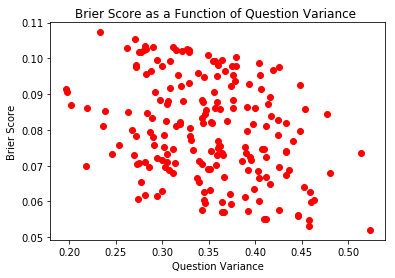

In [96]:
import matplotlib.pyplot as plt
plt.plot(values, brier_score, 'ro')
plt.xlabel('Question Variance')
plt.ylabel('Brier Score')
plt.title('Brier Score as a Function of Question Variance ')
plt.show()


In [67]:
r# Function to get Residual Values, given a list, and a specified number of answer choices
# We can presume for a Binary Question, the value for Option 2 that the user assigns is 1 - the value that this user assigns for option 1.
def getVariance_Residual_Values(user_id_list, numchoices):
    residuals = []
    import math
    sum = 0
    if(numchoices == 1):
        for k in range(len(user_id_list)):
            # Returns the probability assigned to Option 1
            option_1_value = user_id_list['forecast'].reset_index().ix[k]['forecast'][0]['value']
            question_length = len(user_id_list['forecast'].reset_index().ix[k]['forecast'])
            residual = abs(option_1_value - 100/(question_length + 1))
            print(residual)
            residuals.append(residual)
    else:
        for k in range(len(user_id_list)):
            for n in range(numchoices):
                option_n_value = user_id_list['forecast'].reset_index().ix[k]['forecast'][n]['value']
                residual = abs(option_n_value - 100/(numchoices))
                

                
    return residuals


NameError: name 'r' is not defined

In [ ]:
def get_Brier_Scores(user_id_list, numchoices):
    

In [ ]:
def getCorrectness_Residual_Values(user_id_list, numchoices):
    residuals = []
    import math
    sum = 0
    if(numchoices == 1):
        

In [28]:
binary_residuals = getVariance_Residual_Values(binary_questions, 1)

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


30.0
45.0
50.0
10.0
20.0
40.0
30.0
25.0
28.0
25.0
20.0
30.0
50.0
25.0
50.0
20.0
35.0
15.0
15.0
40.0
50.0
34.0
45.0
50.0
35.0
50.0
25.0
50.0
30.0
45.0
10.0
10.0
25.0
25.0
35.0
35.0
50.0
50.0
20.0
10.0
15.0
15.0
33.0
33.0
31.0
31.0
31.0
30.0
30.0
30.0
30.0
28.0
27.0
27.0
27.0
17.0
17.0
17.0
17.0
17.0
17.0
21.0
21.0
25.0
25.0
15.0
28.0
6.000000000000007
18.0
23.0
40.0
25.0
20.0
25.0
50.0
30.0
50.0
23.0
5.000000000000007
37.0
7.999999999999993
30.0
25.0
48.0
30.0
30.0
43.0
47.0
32.0
36.0
45.0
25.0
10.0
50.0
10.0
5.000000000000007
50.0
15.0
25.0
10.0
15.0
50.0
20.0
25.0
5.000000000000007
2.0
25.0
40.0
0.0
45.0
20.0
20.0
10.0
35.0
36.0
46.0
20.0
0.0
30.0
45.0
50.0
35.0
50.0
35.0
20.0
5.0
15.0
11.0
50.0
49.0
49.0
50.0
46.0
49.0
45.0
46.0
47.0
50.0
50.0
45.0
50.0
48.0
50.0
50.0
40.0
42.0
33.0
50.0
0.0
50.0
37.0
43.0
50.0
31.0
50.0
45.0
50.0
45.0
47.0
50.0
5.0
25.0
35.0
50.0
50.0
50.0
40.0
50.0
50.0
10.0
25.0
45.0
48.0
50.0
48.0
50.0
50.0
47.0
10.0
50.0
50.0
45.0
45.0
45.0
47.0
49.0
49.0
49.0
4

35.0
40.0
47.0
50.0
40.0
15.0
48.0
49.0
49.0
49.0
49.0
45.0
50.0
49.0
50.0
45.0
48.0
50.0
41.0
48.0
49.0
49.0
45.0
49.0
45.0
30.0
49.0
30.0
36.0
45.0
46.0
45.0
40.0
40.0
45.0
50.0
49.0
49.0
50.0
15.0
48.0
45.0
35.0
47.0
48.0
48.0
24.0
45.0
5.0
49.0
48.0
49.0
48.0
45.0
48.0
48.0
45.0
45.0
15.0
43.0
46.0
45.0
49.0
50.0
50.0
50.0
35.0
50.0
49.0
45.0
46.0
48.0
45.0
48.0
20.0
49.0
35.0
45.0
25.0
44.0
45.0
50.0
50.0
50.0
50.0
50.0
48.0
49.0
40.0
45.0
48.0
48.0
48.0
15.0
48.0
48.0
50.0
46.0
45.0
45.0
48.0
49.0
47.0
50.0
50.0
46.0
49.0
45.0
50.0
47.0
45.0
45.0
48.0
0.0
49.0
45.0
45.0
50.0
45.0
49.0
40.0
49.0
49.0
45.0
45.0
40.0
49.0
45.0
48.0
35.0
49.0
50.0
45.0
50.0
49.0
50.0
30.0
49.0
35.0
19.0
50.0
35.0
50.0
48.0
45.0
48.0
26.0
14.0
17.0
49.0
49.0
40.0
46.0
42.0
49.0
48.0
50.0
45.0
48.0
40.0
45.0
45.0
48.0
25.0
48.0
50.0
48.0
49.0
50.0
25.0
45.0
45.0
5.000000000000007
50.0
50.0
45.0
50.0
48.0
45.0
44.0
49.0
45.0
50.0
45.0
47.0
30.0
45.0
5.000000000000007
49.0
10.0
25.0
35.0
49.0
45.0
30.0
5

45.0
50.0
10.0
49.0
50.0
41.0
50.0
45.0
45.0
0.0
50.0
40.0
30.0
45.0
44.0
50.0
45.0
15.0
50.0
45.0
50.0
49.0
45.0
50.0
50.0
49.0
50.0
50.0
49.0
44.0
50.0
49.0
50.0
45.0
40.0
40.0
50.0
40.0
45.0
40.0
50.0
40.0
40.0
45.0
50.0
48.0
50.0
50.0
45.0
49.0
49.0
45.0
44.0
49.0
48.0
50.0
35.0
25.0
17.0
20.0
50.0
50.0
49.0
48.0
49.0
50.0
49.0
50.0
35.0
45.0
49.0
42.0
46.0
48.0
50.0
48.0
46.0
30.0
45.0
48.0
35.0
38.0
50.0
46.0
48.0
50.0
47.0
50.0
45.0
50.0
50.0
46.0
46.0
45.0
49.0
48.0
48.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
35.0
47.0
48.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
30.0
20.0
10.0
15.0
47.0
5

5.0
25.0
40.0
35.0
25.0
20.0
50.0
20.0
50.0
5.0
50.0
30.0
40.0
50.0
23.0
50.0
42.0
50.0
50.0
45.0
50.0
38.0
10.0
40.0
35.0
50.0
15.0
46.0
50.0
50.0
43.0
40.0
36.0
32.0
20.0
34.0
38.0
47.0
46.0
45.0
46.0
47.0
48.0
50.0
50.0
45.0
50.0
50.0
35.0
8.0
45.0
45.0
46.0
35.0
35.0
35.0
40.0
46.0
48.0
49.0
50.0
45.0
48.0
50.0
49.0
50.0
40.0
44.0
45.0
48.0
50.0
50.0
45.0
50.0
50.0
45.0
37.0
49.0
45.0
42.0
50.0
38.0
49.0
50.0
40.0
28.0
50.0
40.0
15.0
20.0
40.0
25.0
40.0
45.0
30.0
40.0
48.0
25.0
50.0
45.0
50.0
40.0
25.0
5.0
15.0
5.000000000000007
15.0
50.0
40.0
40.0
47.0
40.0
45.0
35.0
45.0
46.0
10.0
20.0
20.0
40.0
5.000000000000007
20.0
20.0
35.0
7.0
44.0
45.0
47.0
35.0
40.0
45.0
35.0
50.0
5.0
50.0
45.0
47.0
35.0
40.0
50.0
49.0
49.0
49.0
30.0
45.0
48.0
45.0
50.0
40.0
35.0
50.0
40.0
45.0
45.0
20.0
40.0
50.0
25.0
38.0
35.0
45.0
50.0
50.0
30.0
45.0
18.0
45.0
45.0
49.0
47.0
49.0
40.0
44.0
40.0
50.0
45.0
46.0
30.0
49.0
49.0
39.0
38.0
5.0
49.0
39.0
25.0
50.0
48.0
15.0
45.0
50.0
46.0
50.0
50.0
48.0
35.0
4

49.0
49.0
49.0
49.0
49.0
42.0
41.0
41.0
41.0
46.0
47.0
47.0
47.0
47.0
47.0
48.0
50.0
50.0
50.0
50.0
50.0
15.0
5.0
15.0
25.0
45.0
50.0
50.0
50.0
0.0
0.0
15.0
5.000000000000007
35.0
36.0
40.0
0.0
10.0
30.0
40.0
48.0
20.0
40.0
45.0
50.0
30.0
25.0
20.0
17.0
40.0
10.0
20.0
10.0
25.0
35.0
15.0
45.0
10.0
50.0
40.0
45.0
49.0
40.0
50.0
30.0
35.0
50.0
42.0
40.0
10.0
0.0
30.0
35.0
45.0
49.0
50.0
10.0
30.0
35.0
15.0
38.0
35.0
50.0
50.0
15.0
50.0
45.0
25.0
50.0
38.0
20.0
50.0
25.0
45.0
15.0
44.0
50.0
50.0
25.0
49.0
23.0
30.0
49.0
15.0
1.0
25.0
45.0
30.0
49.0
45.0
20.0
45.0
40.0
49.0
10.0
10.0
10.0
0.0
30.0
50.0
0.0
35.0
45.0
49.0
50.0
50.0
50.0
50.0
35.0
15.0
0.0
15.0
50.0
40.0
49.0
30.0
10.0
50.0
25.0
35.0
20.0
50.0
45.0
35.0
35.0
44.0
45.0
35.0
30.0
40.0
25.0
45.0
48.0
45.0
45.0
50.0
50.0
47.0
10.0
15.0
50.0
50.0
45.0
35.0
50.0
30.0
25.0
10.0
43.0
40.0
45.0
45.0
25.0
45.0
39.0
48.0
0.0
40.0
50.0
30.0
45.0
45.0
45.0
50.0
50.0
50.0
0.0
15.0
15.0
25.0
35.0
30.0
34.0
50.0
45.0
47.0
35.0
40.0
48.0
47.

45.0
47.0
45.0
43.0
49.0
49.0
49.0
45.0
45.0
50.0
50.0
43.0
49.0
48.0
46.0
48.0
50.0
45.0
49.0
49.0
49.0
50.0
48.0
50.0
50.0
49.0
49.0
48.0
50.0
50.0
46.0
48.0
36.0
48.0
45.0
35.0
45.0
50.0
45.0
45.0
41.0
49.0
49.0
49.0
49.0
47.0
49.0
47.0
45.0
47.0
45.0
49.0
20.0
49.0
0.0
49.0
45.0
40.0
47.0
45.0
45.0
50.0
25.0
49.0
46.0
48.0
48.0
35.0
49.0
46.0
45.0
45.0
45.0
50.0
49.0
50.0
50.0
49.0
46.0
40.0
35.0
45.0
46.0
50.0
45.0
48.0
49.0
48.0
50.0
50.0
35.0
49.0
49.0
49.0
49.0
44.0
49.0
50.0
49.0
50.0
49.0
49.0
49.0
49.0
50.0
49.0
49.0
45.0
48.0
49.0
45.0
48.0
50.0
49.0
47.0
48.0
50.0
45.0
46.0
50.0
49.0
45.0
48.0
45.0
49.0
45.0
49.0
49.0
45.0
50.0
0.0
48.0
45.0
48.0
48.0
48.0
49.0
40.0
50.0
49.0
48.0
50.0
50.0
50.0
49.0
50.0
48.0
35.0
41.0
48.0
48.0
48.0
49.0
48.0
50.0
49.0
45.0
50.0
49.0
50.0
49.0
35.0
40.0
45.0
49.0
49.0
45.0
48.0
50.0
49.0
49.0
47.0
49.0
49.0
50.0
50.0
50.0
45.0
50.0
50.0
50.0
47.0
45.0
47.0
50.0
50.0
50.0
25.0
0.0
45.0
47.0
48.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
49.0
49.

45.0
45.0
45.0
45.0
45.0
45.0
49.0
48.0
50.0
37.0
49.0
45.0
10.0
30.0
40.0
40.0
45.0
50.0
49.0
35.0
50.0
35.0
43.0
31.0
48.0
40.0
35.0
40.0
49.0
30.0
49.0
50.0
49.0
30.0
49.0
50.0
45.0
49.0
50.0
35.0
50.0
50.0
40.0
45.0
25.0
42.0
5.000000000000007
45.0
50.0
42.0
50.0
40.0
35.0
47.0
49.0
35.0
46.0
45.0
40.0
45.0
50.0
40.0
48.0
49.0
47.0
35.0
49.0
40.0
47.0
50.0
49.0
35.0
50.0
40.0
49.0
50.0
49.0
49.0
40.0
40.0
5.000000000000007
15.0
34.0
37.0
32.0
25.0
28.0
32.0
28.0
30.0
15.0
5.000000000000007
0.0
45.0
50.0
50.0
15.0
0.0
10.0
5.0
20.0
0.0
10.0
50.0
24.0
5.000000000000007
50.0
25.0
40.0
20.0
20.0
45.0
45.0
50.0
10.0
25.0
32.0
38.0
42.0
45.0
0.0
30.0
50.0
45.0
45.0
50.0
50.0
40.0
45.0
20.0
40.0
50.0
17.0
35.0
40.0
32.0
24.0
40.0
32.0
40.0
43.0
50.0
35.0
50.0
5.0
15.0
47.0
50.0
20.0
20.0
50.0
38.0
42.0
35.0
40.0
45.0
50.0
15.0
35.0
5.000000000000007
25.0
30.0
50.0
10.0
45.0
35.0
2.0
50.0
50.0
40.0
5.000000000000007
13.0
7.999999999999993
50.0
50.0
40.0
50.0
50.0
40.0
40.0
45.0
40.0
48.0
1

48.0
48.0
49.0
49.0
40.0
40.0
45.0
40.0
35.0
40.0
45.0
45.0
45.0
47.0
35.0
45.0
15.0
5.0
45.0
50.0
50.0
40.0
40.0
10.0
45.0
30.0
45.0
48.0
25.0
45.0
8.0
50.0
48.0
21.999999999999996
40.0
35.0
50.0
50.0
45.0
45.0
40.0
46.0
49.0
5.0
27.0
49.0
35.0
35.0
50.0
15.0
15.0
50.0
48.0
45.0
45.0
15.0
25.0
40.0
45.0
45.0
49.0
20.0
45.0
45.0
45.0
25.0
40.0
48.0
50.0
35.0
48.0
39.0
40.0
46.0
38.0
15.0
40.0
50.0
30.0
45.0
35.0
15.0
10.0
25.0
45.0
45.0
45.0
45.0
45.0
50.0
25.0
50.0
34.0
45.0
49.0
41.0
45.0
35.0
15.0
48.0
41.0
44.0
49.0
40.0
45.0
10.0
50.0
0.0
50.0
35.0
45.0
49.0
44.0
50.0
49.0
50.0
48.0
35.0
50.0
30.0
49.0
50.0
47.0
5.0
42.0
45.0
50.0
50.0
25.0
45.0
46.0
25.0
45.0
48.0
30.0
45.0
48.0
49.0
48.0
35.0
45.0
50.0
45.0
40.0
25.0
32.0
14.0
0.0
15.0
45.0
47.0
50.0
50.0
45.0
48.0
49.0
50.0
48.0
50.0
50.0
48.0
0.0
49.0
40.0
35.0
50.0
50.0
50.0
50.0
50.0
48.0
50.0
50.0
50.0
50.0
40.0
49.0
50.0
50.0
49.0
49.0
49.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.

35.0
33.0
45.0
45.0
50.0
50.0
50.0
45.0
49.0
50.0
35.0
43.0
45.0
42.0
32.0
40.0
49.0
46.0
45.0
45.0
45.0
50.0
45.0
45.0
36.0
35.0
15.0
30.0
35.0
49.0
45.0
40.0
40.0
50.0
37.0
40.0
15.0
49.0
45.0
15.0
40.0
50.0
50.0
45.0
45.0
35.0
40.0
48.0
50.0
45.0
10.0
42.0
40.0
45.0
0.0
30.0
49.0
23.0
5.0
45.0
40.0
40.0
46.0
48.0
32.0
45.0
47.0
50.0
49.0
50.0
48.0
50.0
50.0
42.0
18.0
50.0
43.0
30.0
50.0
40.0
40.0
40.0
50.0
45.0
35.0
43.0
45.0
47.0
35.0
35.0
40.0
35.0
45.0
50.0
45.0
40.0
45.0
6.000000000000007
40.0
49.0
45.0
50.0
0.0
49.0
48.0
45.0
38.0
42.0
40.0
35.0
35.0
45.0
32.0
20.0
32.0
50.0
10.0
48.0
49.0
47.0
48.0
47.0
48.0
50.0
40.0
48.0
35.0
35.0
49.0
49.0
0.0
50.0
43.0
40.0
45.0
45.0
40.0
38.0
35.0
38.0
48.0
15.0
48.0
49.0
45.0
50.0
15.0
30.0
50.0
50.0
42.0
45.0
40.0
40.0
46.0
25.0
50.0
45.0
25.0
48.0
50.0
49.0
35.0
50.0
45.0
45.0
45.0
39.0
49.0
43.0
50.0
50.0
35.0
50.0
42.0
50.0
49.0
45.0
40.0
45.0
45.0
50.0
25.0
35.0
47.0
48.0
35.0
49.0
45.0
40.0
40.0
49.0
39.0
35.0
50.0
25.0
5.000000000

45.0
50.0
45.0
50.0
15.0
45.0
45.0
45.0
48.0
49.0
48.0
35.0
15.0
48.0
42.0
49.0
50.0
50.0
40.0
40.0
47.0
50.0
47.0
48.0
50.0
45.0
49.0
49.0
47.0
48.0
50.0
40.0
40.0
45.0
50.0
45.0
50.0
41.0
47.0
40.0
35.0
45.0
40.0
40.0
30.0
49.0
45.0
40.0
47.0
45.0
50.0
45.0
45.0
45.0
47.0
48.0
49.0
47.0
45.0
47.0
49.0
40.0
35.0
45.0
45.0
35.0
39.0
50.0
45.0
45.0
45.0
48.0
40.0
45.0
45.0
45.0
49.0
35.0
49.0
50.0
49.0
40.0
46.0
46.0
45.0
50.0
45.0
49.0
47.0
30.0
35.0
47.0
48.0
47.0
45.0
50.0
35.0
49.0
48.0
49.0
48.0
45.0
49.0
50.0
45.0
45.0
45.0
48.0
44.0
45.0
49.0
45.0
25.0
48.0
45.0
42.0
49.0
49.0
35.0
49.0
45.0
48.0
48.0
25.0
46.0
47.0
42.0
40.0
40.0
45.0
45.0
47.0
40.0
45.0
50.0
45.0
49.0
40.0
49.0
45.0
45.0
35.0
47.0
35.0
45.0
46.0
45.0
47.0
40.0
45.0
45.0
45.0
49.0
50.0
50.0
35.0
49.0
49.0
47.0
49.0
40.0
45.0
45.0
48.0
40.0
45.0
48.0
50.0
48.0
48.0
40.0
47.0
50.0
47.0
40.0
40.0
49.0
50.0
45.0
39.0
45.0
50.0
40.0
45.0
25.0
25.0
48.0
47.0
25.0
50.0
49.0
48.0
49.0
49.0
0.0
45.0
49.0
45.0
35.0
35.0
3

5.000000000000007
35.0
40.0
35.0
5.000000000000007
25.0
30.0
38.0
37.0
28.0
4.0
0.0
35.0
38.0
15.0
25.0
11.0
35.0
25.0
14.0
35.0
15.0
18.0
10.0
25.0
10.0
5.000000000000007
10.0
10.0
35.0
25.0
5.0
40.0
7.999999999999993
20.0
30.0
3.0
35.0
35.0
15.0
35.0
35.0
17.0
5.0
27.0
28.0
20.0
25.0
35.0
27.0
30.0
25.0
23.0
25.0
0.0
15.0
35.0
15.0
29.0
15.0
15.0
35.0
20.0
5.000000000000007
15.0
10.0
30.0
30.0
25.0
5.0
35.0
35.0
15.0
10.0
15.0
20.0
35.0
25.0
25.0
37.0
35.0
1.0
15.0
16.0
10.0
35.0
25.0
25.0
15.0
10.0
9.0
15.0
20.0
20.0
16.0
15.0
20.0
30.0
25.0
25.0
15.0
20.0
50.0
17.0
45.0
11.0
20.0
35.0
10.0
1.0
0.0
6.000000000000007
40.0
10.0
35.0
22.0
25.0
15.0
11.0
9.0
10.0
25.0
49.0
5.0
3.0
35.0
35.0
25.0
35.0
25.0
15.0
15.0
6.999999999999993
14.0
5.000000000000007
13.0
35.0
9.0
9.0
30.0
35.0
35.0
20.0
20.0
9.0
35.0
30.0
1.0
30.0
10.0
15.0
35.0
20.0
35.0
15.0
25.0
3.0
15.0
17.0
30.0
15.0
15.0
25.0
5.0
15.0
30.0
17.0
33.0
25.0
50.0
5.000000000000007
15.0
20.0
10.0
5.000000000000007
5.0000000000000

50.0
50.0
50.0
50.0
50.0
49.0
50.0
45.0
50.0
50.0
47.0
50.0
45.0
50.0
45.0
45.0
50.0
49.0
45.0
50.0
50.0
40.0
50.0
50.0
50.0
50.0
50.0
50.0
49.0
50.0
50.0
49.0
45.0
49.0
50.0
50.0
48.0
50.0
48.0
45.0
38.0
0.0
10.0
42.0
43.0
25.0
45.0
50.0
15.0
45.0
48.0
49.0
49.0
50.0
50.0
50.0
50.0
50.0
50.0
49.0
50.0
40.0
50.0
45.0
45.0
30.0
40.0
30.0
45.0
10.0
45.0
41.0
44.0
45.0
45.0
5.000000000000007
35.0
45.0
25.0
0.0
45.0
45.0
45.0
40.0
21.999999999999996
48.0
40.0
25.0
45.0
42.0
15.0
48.0
45.0
49.0
33.0
13.0
35.0
30.0
0.0
40.0
25.0
25.0
35.0
35.0
45.0
30.0
41.0
36.0
49.0
47.0
47.0
40.0
45.0
40.0
47.0
47.0
35.0
25.0
39.0
30.0
40.0
41.0
47.0
45.0
50.0
42.0
4.0
5.000000000000007
49.0
50.0
49.0
45.0
40.0
50.0
50.0
40.0
50.0
50.0
35.0
50.0
45.0
50.0
30.0
30.0
33.0
50.0
45.0
45.0
49.0
44.0
6.0
2.0
18.0
27.0
28.0
28.0
28.0
28.0
28.0
44.0
47.0
48.0
48.0
47.0
47.0
47.0
47.0
49.0
49.0
49.0
49.0
49.0
48.0
13.0
33.0
30.0
50.0
17.0
6.999999999999993
50.0
50.0
40.0
50.0
50.0
45.0
25.0
50.0
30.0
35.0
25.0
25.

35.0
45.0
28.0
29.0
17.0
25.0
15.0
40.0
29.0
45.0
7.999999999999993
30.0
15.0
40.0
45.0
20.0
25.0
20.0
30.0
35.0
20.0
45.0
35.0
35.0
22.0
16.0
20.0
25.0
35.0
35.0
30.0
50.0
20.0
35.0
40.0
15.0
22.0
18.0
35.0
30.0
25.0
25.0
29.0
25.0
35.0
30.0
20.0
40.0
25.0
25.0
32.0
15.0
49.0
25.0
25.0
30.0
30.0
19.0
17.0
25.0
20.0
35.0
43.0
30.0
19.0
1.0
25.0
20.0
40.0
25.0
25.0
5.000000000000007
40.0
45.0
34.0
35.0
25.0
20.0
0.0
13.0
25.0
10.0
30.0
35.0
10.0
25.0
25.0
15.0
35.0
15.0
35.0
25.0
40.0
25.0
29.0
25.0
25.0
25.0
25.0
45.0
40.0
2.0
40.0
25.0
40.0
15.0
15.0
30.0
25.0
34.0
10.0
40.0
35.0
35.0
10.0
37.0
30.0
35.0
26.0
25.0
30.0
15.0
25.0
25.0
12.0
50.0
35.0
25.0
20.0
40.0
15.0
36.0
30.0
10.0
15.0
35.0
20.0
30.0
20.0
25.0
25.0
20.0
30.0
35.0
35.0
35.0
35.0
35.0
25.0
35.0
20.0
28.0
30.0
45.0
45.0
35.0
5.000000000000007
40.0
0.0
25.0
15.0
40.0
20.0
15.0
35.0
30.0
10.0
45.0
15.0
25.0
50.0
20.0
30.0
25.0
0.0
5.000000000000007
25.0
29.0
38.0
27.0
32.0
27.0
35.0
25.0
6.000000000000007
35.0
28.0
19.0


30.0
10.0
50.0
40.0
35.0
5.0
40.0
46.0
40.0
15.0
50.0
40.0
46.0
48.0
29.0
46.0
45.0
45.0
15.0
50.0
5.0
45.0
50.0
45.0
17.0
5.0
25.0
50.0
46.0
47.0
48.0
49.0
50.0
50.0
35.0
40.0
40.0
47.0
50.0
38.0
39.0
41.0
42.0
43.0
42.0
43.0
44.0
47.0
42.0
48.0
45.0
50.0
48.0
48.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
49.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
50.0
35.0
48.0
45.0
46.0
48.0
49.0
50.0
50.0
50.0
49.0
50.0
45.0
48.0
50.0
45.0
15.0
47.0
50.0
50.0
47.0
48.0
45.0
45.0
45.0
48.0
48.0
40.0
48.0
47.0
49.0
47.0
49.0
50.0
45.0
45.0
49.0
49.0
47.0
45.0
50.0
49.0
47.0
47.0
49.0
48.0
50.0
49.0
49.0
49.0
49.0
50.0
45.0
45.0
50.0
48.0
47.0
45.0
47.0
48.0
41.0
48.0
48.0
50.0
45.0
48.0
49.0
48.0
49.0
48.0
49.0
50.0
45.0
49.0
50.0
45.0
49.0
25.0
49.0
48.0
48.0
49.0
49.0
49.0
45.0
42.0
45.0
46.0
49.0
48.0
50.0
49.0
47.0
49.0
45.0
49.

49.0
25.0
46.0
50.0
49.0
25.0
49.0
31.0
25.0
40.0
35.0
25.0
48.0
40.0
35.0
45.0
0.0
15.0
45.0
3.0
45.0
40.0
49.0
46.0
30.0
10.0
47.0
40.0
47.0
47.0
40.0
15.0
47.0
50.0
45.0
47.0
50.0
35.0
40.0
10.0
40.0
40.0
15.0
17.0
50.0
50.0
49.0
50.0
35.0
35.0
45.0
35.0
30.0
50.0
45.0
25.0
32.0
48.0
45.0
47.0
45.0
38.0
50.0
5.0
45.0
48.0
25.0
25.0
45.0
35.0
45.0
45.0
45.0
40.0
50.0
49.0
40.0
25.0
25.0
0.0
44.0
45.0
0.0
45.0
25.0
49.0
35.0
47.0
15.0
40.0
30.0
45.0
35.0
48.0
38.0
5.000000000000007
30.0
40.0
30.0
45.0
35.0
40.0
50.0
45.0
41.0
35.0
20.0
47.0
10.0
49.0
47.0
25.0
25.0
40.0
25.0
46.0
50.0
25.0
40.0
35.0
45.0
45.0
10.0
40.0
44.0
50.0
25.0
28.0
40.0
35.0
35.0
48.0
33.0
40.0
40.0
48.0
50.0
50.0
25.0
30.0
48.0
25.0
25.0
35.0
45.0
25.0
50.0
49.0
46.0
40.0
49.0
15.0
49.0
50.0
40.0
40.0
25.0
0.0
1.0
45.0
40.0
45.0
37.0
45.0
45.0
40.0
27.0
25.0
15.0
48.0
45.0
15.0
20.0
45.0
45.0
10.0
50.0
25.0
48.0
30.0
10.0
20.0
40.0
49.0
48.0
45.0
35.0
40.0
29.0
45.0
45.0
30.0
25.0
35.0
35.0
35.0
35.0
50.0
38.0

15.0
27.0
5.0
5.0
25.0
40.0
38.0
45.0
5.000000000000007
15.0
20.0
49.0
45.0
35.0
40.0
28.0
5.0
2.0
30.0
2.0
5.0
45.0
10.0
45.0
25.0
25.0
9.0
30.0
5.000000000000007
35.0
40.0
40.0
20.0
50.0
15.0
5.0
30.0
10.0
10.0
15.0
30.0
10.0
49.0
15.0
49.0
5.0
40.0
35.0
10.0
45.0
35.0
45.0
13.0
49.0
32.0
20.0
0.0
15.0
42.0
25.0
50.0
49.0
45.0
10.0
45.0
45.0
20.0
10.0
50.0
10.0
25.0
0.0
20.0
10.0
50.0
45.0
25.0
15.0
16.0
20.0
25.0
45.0
47.0
35.0
1.0
15.0
43.0
25.0
35.0
49.0
8.0
35.0
38.0
35.0
25.0
10.0
10.0
50.0
43.0
25.0
20.0
45.0
40.0
30.0
35.0
45.0
25.0
41.0
49.0
35.0
49.0
40.0
50.0
50.0
49.0
15.0
30.0
0.0
45.0
30.0
10.0
30.0
25.0
15.0
50.0
25.0
25.0
35.0
38.0
20.0
45.0
40.0
45.0
40.0
45.0
5.000000000000007
5.0
45.0
45.0
30.0
48.0
49.0
30.0
25.0
40.0
35.0
10.0
35.0
47.0
48.0
23.0
40.0
5.000000000000007
40.0
45.0
35.0
15.0
15.0
15.0
45.0
1.0
0.0
15.0
49.0
40.0
50.0
5.000000000000007
40.0
15.0
50.0
45.0
45.0
45.0
42.0
30.0
20.0
45.0
35.0
24.0
25.0
30.0
40.0
35.0
32.0
45.0
15.0
41.0
35.0
45.0
25.0
40

45.0
45.0
45.0
20.0
35.0
40.0
40.0
50.0
49.0
47.0
49.0
49.0
49.0
44.0
50.0
35.0
45.0
45.0
30.0
49.0
10.0
45.0
48.0
5.000000000000007
30.0
47.0
45.0
39.0
40.0
43.0
40.0
49.0
25.0
35.0
48.0
48.0
48.0
50.0
45.0
45.0
45.0
5.0
50.0
45.0
17.0
35.0
40.0
45.0
45.0
47.0
43.0
25.0
48.0
40.0
45.0
28.0
40.0
25.0
40.0
25.0
48.0
46.0
45.0
49.0
45.0
25.0
35.0
30.0
48.0
30.0
45.0
35.0
40.0
42.0
45.0
50.0
40.0
43.0
34.0
45.0
45.0
35.0
35.0
30.0
47.0
47.0
47.0
25.0
45.0
25.0
30.0
35.0
15.0
45.0
50.0
45.0
50.0
10.0
45.0
50.0
40.0
45.0
47.0
45.0
35.0
50.0
40.0
40.0
50.0
25.0
45.0
40.0
47.0
38.0
45.0
37.0
25.0
25.0
45.0
37.0
46.0
0.0
47.0
35.0
10.0
45.0
45.0
45.0
40.0
45.0
50.0
43.0
10.0
30.0
50.0
48.0
28.0
48.0
50.0
50.0
48.0
45.0
35.0
45.0
20.0
44.0
49.0
15.0
49.0
49.0
41.0
40.0
35.0
5.0
40.0
35.0
38.0
35.0
18.0
43.0
49.0
45.0
30.0
45.0
45.0
35.0
40.0
40.0
40.0
45.0
45.0
50.0
35.0
24.0
40.0
50.0
40.0
40.0
48.0
17.0
5.000000000000007
45.0
5.0
50.0
40.0
45.0
35.0
48.0
45.0
49.0
25.0
48.0
49.0
25.0
30.0
35.

35.0
26.0
48.0
35.0
35.0
20.0
30.0
45.0
30.0
40.0
25.0
1.0
25.0
35.0
40.0
30.0
40.0
35.0
40.0
5.000000000000007
30.0
45.0
40.0
40.0
48.0
45.0
10.0
35.0
49.0
30.0
30.0
35.0
10.0
25.0
35.0
38.0
38.0
30.0
17.0
40.0
40.0
25.0
48.0
35.0
15.0
25.0
25.0
45.0
12.0
42.0
15.0
15.0
49.0
15.0
43.0
45.0
40.0
30.0
40.0
42.0
40.0
35.0
46.0
30.0
35.0
35.0
25.0
40.0
40.0
15.0
18.0
30.0
25.0
25.0
20.0
30.0
40.0
35.0
15.0
20.0
35.0
39.0
39.0
0.0
45.0
0.0
25.0
30.0
35.0
40.0
16.0
40.0
8.0
40.0
10.0
40.0
5.0
15.0
44.0
35.0
45.0
40.0
0.0
35.0
30.0
15.0
33.0
20.0
25.0
33.0
40.0
43.0
35.0
35.0
20.0
35.0
45.0
33.0
37.0
15.0
48.0
5.000000000000007
40.0
40.0
35.0
10.0
45.0
15.0
30.0
20.0
47.0
49.0
50.0
30.0
10.0
0.0
47.0
15.0
0.0
30.0
45.0
42.0
45.0
45.0
25.0
40.0
25.0
40.0
30.0
25.0
30.0
45.0
40.0
30.0
50.0
45.0
35.0
30.0
41.0
0.0
45.0
20.0
10.0
30.0
27.0
43.0
50.0
30.0
35.0
30.0
40.0
35.0
25.0
39.0
25.0
0.0
5.000000000000007
30.0
15.0
45.0
45.0
0.0
15.0
35.0
40.0
40.0
15.0
30.0
20.0
35.0
35.0
50.0
30.0
0.0
40.

45.0
37.0
49.0
35.0
20.0
15.0
48.0
20.0
35.0
3.0
15.0
45.0
45.0
45.0
40.0
45.0
45.0
50.0
40.0
35.0
0.0
50.0
35.0
45.0
45.0
50.0
5.0
49.0
49.0
35.0
49.0
45.0
10.0
35.0
0.0
48.0
25.0
5.0
49.0
35.0
40.0
45.0
35.0
35.0
40.0
45.0
45.0
40.0
0.0
0.0
25.0
35.0
25.0
40.0
35.0
45.0
45.0
50.0
45.0
45.0
0.0
35.0
35.0
13.0
35.0
25.0
45.0
50.0
47.0
20.0
35.0
49.0
25.0
40.0
30.0
50.0
45.0
15.0
48.0
30.0
30.0
30.0
25.0
45.0
40.0
40.0
50.0
49.0
49.0
25.0
35.0
49.0
45.0
45.0
50.0
37.0
35.0
36.0
40.0
10.0
25.0
0.0
45.0
49.0
42.0
45.0
5.0
48.0
15.0
30.0
35.0
27.0
19.0
47.0
35.0
30.0
49.0
49.0
35.0
40.0
10.0
35.0
40.0
10.0
45.0
25.0
45.0
49.0
50.0
50.0
45.0
50.0
49.0
30.0
40.0
49.0
35.0
30.0
30.0
45.0
25.0
5.0
49.0
40.0
50.0
25.0
40.0
40.0
35.0
35.0
48.0
5.000000000000007
49.0
49.0
45.0
47.0
40.0
35.0
35.0
45.0
35.0
49.0
35.0
25.0
50.0
25.0
45.0
35.0
40.0
25.0
45.0
20.0
40.0
40.0
35.0
25.0
18.0
20.0
50.0
49.0
40.0
35.0
35.0
40.0
44.0
45.0
25.0
5.0
10.0
10.0
45.0
50.0
15.0
40.0
30.0
10.0
45.0
35.0
49.0
5.0


50.0
20.0
45.0
44.0
48.0
40.0
35.0
49.0
50.0
47.0
0.0
5.0
35.0
49.0
45.0
48.0
40.0
49.0
49.0
50.0
47.0
45.0
13.0
32.0
48.0
38.0
50.0
30.0
47.0
50.0
30.0
49.0
48.0
45.0
46.0
50.0
45.0
48.0
49.0
50.0
0.0
45.0
5.000000000000007
45.0
50.0
40.0
45.0
45.0
47.0
45.0
45.0
30.0
50.0
40.0
42.0
44.0
45.0
47.0
48.0
50.0
45.0
13.0
35.0
49.0
49.0
40.0
44.0
47.0
45.0
40.0
47.0
18.0
45.0
48.0
40.0
45.0
45.0
47.0
48.0
50.0
45.0
46.0
49.0
49.0
45.0
45.0
44.0
45.0
45.0
48.0
50.0
35.0
49.0
35.0
48.0
48.0
49.0
48.0
45.0
35.0
45.0
45.0
40.0
46.0
45.0
47.0
45.0
45.0
40.0
45.0
48.0
49.0
41.0
30.0
15.0
49.0
45.0
48.0
48.0
49.0
49.0
15.0
45.0
44.0
47.0
47.0
50.0
40.0
45.0
32.0
35.0
45.0
0.0
44.0
45.0
50.0
5.000000000000007
25.0
50.0
49.0
45.0
45.0
50.0
48.0
45.0
50.0
49.0
20.0
40.0
40.0
40.0
45.0
45.0
40.0
45.0
45.0
47.0
47.0
25.0
43.0
49.0
49.0
25.0
25.0
50.0
20.0
48.0
29.0
45.0
39.0
25.0
30.0
49.0
25.0
20.0
50.0
40.0
40.0
45.0
44.0
45.0
47.0
45.0
45.0
45.0
35.0
45.0
48.0
45.0
45.0
45.0
40.0
15.0
0.0
48.0
45.0

45.0
50.0
45.0
40.0
40.0
49.0
47.0
49.0
45.0
45.0
45.0
50.0
45.0
48.0
45.0
48.0
0.0
48.0
40.0
40.0
50.0
40.0
48.0
49.0
45.0
49.0
30.0
46.0
20.0
45.0
47.0
46.0
49.0
44.0
30.0
48.0
50.0
0.0
42.0
45.0
48.0
49.0
47.0
47.0
50.0
49.0
47.0
25.0
25.0
49.0
25.0
50.0
35.0
45.0
33.0
48.0
45.0
48.0
45.0
35.0
45.0
15.0
50.0
45.0
45.0
43.0
35.0
47.0
35.0
50.0
45.0
48.0
50.0
45.0
40.0
49.0
49.0
50.0
49.0
49.0
50.0
46.0
49.0
45.0
49.0
49.0
47.0
37.0
40.0
48.0
49.0
45.0
25.0
32.0
45.0
47.0
25.0
45.0
45.0
15.0
15.0
48.0
46.0
45.0
49.0
50.0
47.0
49.0
45.0
47.0
48.0
50.0
50.0
15.0
49.0
47.0
40.0
45.0
45.0
50.0
49.0
50.0
45.0
49.0
47.0
46.0
49.0
49.0
39.0
48.0
48.0
48.0
45.0
50.0
45.0
48.0
45.0
40.0
49.0
40.0
50.0
45.0
45.0
49.0
43.0
42.0
49.0
45.0
50.0
45.0
45.0
15.0
47.0
45.0
50.0
39.0
45.0
50.0
49.0
46.0
50.0
25.0
35.0
35.0
45.0
25.0
45.0
50.0
47.0
50.0
46.0
50.0
48.0
45.0
40.0
48.0
49.0
48.0
48.0
49.0
50.0
25.0
45.0
45.0
49.0
49.0
48.0
47.0
42.0
45.0
45.0
45.0
49.0
40.0
48.0
45.0
48.0
49.0
50.0
47.0
45

In [29]:
binary_residuals[:10]

[30.0, 45.0, 50.0, 10.0, 20.0, 40.0, 30.0, 25.0, 28.0, 25.0]

In [30]:
print("Mean is " + str(np.mean(binary_residuals)))
print("Median is " + str(np.median(binary_residuals)))

Mean is 38.7793791246
Median is 45.0


In [9]:
# Type 2: Non-Binary Residuals
# Type 1: Get residuals for questions with 3 answer choices
# Type 2: Residuals for questions with 4 answer choices
# Type 3: Residuals for questions with 5 answer choices. 

NameError: name 'binary_residuals' is not defined

## Get residual for Binary Questions

In [ ]:
binaryresiduals = []

In [ ]:
residualseffort = []
import math
sum = 0
for k in range(len(recruits_effort)):
    option_1_value = recruits_effort['forecast'].reset_index().ix[k]['forecast'][0]['value']
    question_length = len(recruits_effort['forecast'].reset_index().ix[k]['forecast'])
    residualseffort.append(abs(option_1_value - 100/question_length))

# Type 2: Questions with multiple answer choices - trying to gauge user confidence levels

# Divide the Users into different groups based on effort.

In [29]:
turkers = (control_users[control_users['type'] == 'turker'])
recruits = (control_users[control_users['type'] == 'recruit'])
recruits_effort = recruits[recruits['rationale'] != ""]
recruits_lazy =  recruits[recruits['rationale'] == ""]
print(len(recruits_lazy))

22457


In [30]:
recruits_effort[:100]

auto  confidence                created_at downvotes  \
288280  NaN          50  2018-03-28T22:25:51.585Z       NaN   
286777  NaN          50  2018-03-18T14:08:17.968Z       NaN   
286222  NaN          50  2018-03-15T05:12:32.456Z       NaN   
284365  NaN          50  2018-03-07T22:23:41.765Z       NaN   
284394  NaN          50  2018-03-07T21:12:37.380Z       NaN   
281936  NaN          50  2018-04-12T19:54:02.316Z       NaN   
282579  NaN          50  2018-04-23T20:37:55.022Z       NaN   
283249  NaN          50  2018-04-27T17:04:57.796Z       NaN   
290308  NaN          50  2018-04-10T16:45:29.598Z       NaN   
284328  NaN          50  2018-03-07T23:24:35.557Z       NaN   
285689  NaN          50  2018-03-12T02:30:04.392Z       NaN   
286268  NaN          50  2018-03-15T02:06:48.178Z       NaN   
285756  NaN          50  2018-03-13T12:42:52.314Z       NaN   
286782  NaN          50  2018-03-18T12:51:24.880Z       NaN   
293810  NaN          50  2018-05-08T20:21:54.178Z       NaN   
298901  NaN          50  2018-05-16T13:05:58.325Z       NaN   
300058  NaN          50  2018-05-21T09:28:40.786Z       NaN   
304305  NaN          50  2018-05-29T19:59:15.845Z       NaN   
293320  NaN          50  2018-05-07T20:17:35.360Z       NaN   
283537  NaN          50  2018-04-30T17:53:11.270Z       NaN   
283526  NaN          50  2018-04-30T19:06:47.107Z       NaN   
297185  NaN          50  2018-05-15T14:25:19.820Z       NaN   
299974  NaN          50  2018-05-19T15:22:57.770Z       NaN   
300943  NaN          50  2018-05-22T16:08:32.235Z       NaN   
303369  NaN          50  2018-05-25T16:37:29.948Z       NaN   
304328  NaN          50  2018-05-29T19:42:40.690Z       NaN   
284392  NaN          50  2018-03-07T21:27:45.151Z       NaN   
285019  NaN          50  2018-03-09T13:26:53.480Z       NaN   
281937  NaN          50  2018-04-12T19:46:46.555Z       NaN   
286696  NaN          50  2018-03-17T01:38:09.595Z       NaN   
285635  NaN          50  2018-03-12T10:36:40.418Z       NaN   
285760  NaN          50  2018-03-13T11:54:01.655Z       NaN   
285068  NaN          50  2018-03-09T06:51:06.330Z       NaN   
281668  NaN          50  2018-04-13T22:47:32.433Z       NaN   
281667  NaN          50  2018-04-13T22:57:28.740Z       NaN   
289337  NaN          50  2018-04-04T14:14:44.987Z       NaN   
285619  NaN          50  2018-03-12T13:07:45.398Z       NaN   
285118  NaN          50  2018-03-09T03:06:32.050Z       NaN   
288332  NaN          50  2018-03-28T20:20:38.924Z       NaN   
288276  NaN          50  2018-03-28T23:03:22.370Z       NaN   
290060  NaN          50  2018-04-09T20:45:17.306Z       NaN   
281549  NaN          50  2018-04-14T19:09:44.865Z       NaN   
284930  NaN          50  2018-03-09T23:03:06.082Z       NaN   
286705  NaN          50  2018-03-17T00:39:17.598Z       NaN   
284389  NaN          50  2018-03-07T21:39:30.295Z       NaN   
281229  NaN          50  2018-04-16T17:03:36.569Z       NaN   
284402  NaN          50  2018-03-07T20:50:24.369Z       NaN   
286618  NaN          50  2018-03-17T15:25:28.935Z       NaN   
286617  NaN          50  2018-03-17T15:31:01.409Z       NaN   
286852  NaN          50  2018-03-18T00:04:23.936Z       NaN   
288267  NaN          50  2018-03-27T01:49:43.327Z       NaN   
287110  NaN          50  2018-03-20T12:46:03.337Z       NaN   
284921  NaN          50  2018-03-08T00:03:44.412Z       NaN   
285154  NaN          50  2018-03-09T01:16:33.649Z       NaN   
284357  NaN          50  2018-03-07T22:39:36.181Z       NaN   
286697  NaN          50  2018-03-17T01:33:46.838Z       NaN   
286270  NaN          50  2018-03-15T02:05:54.972Z       NaN   
290231  NaN          50  2018-04-09T05:08:20.130Z       NaN   
290395  NaN          50  2018-04-10T02:47:19.053Z       NaN   
286603  NaN          50  2018-03-17T16:13:52.309Z       NaN   
289339  NaN          50  2018-04-04T14:02:55.525Z       NaN   
284853  NaN          50  2018-03-08T03:52:50.919Z       NaN   
284852  NaN          50  2018-03-08T03

In [21]:
# Examine the Accuracy of Answers
# First, we need to examine from the IFPS data what the accuracy of the various answers is. 
# There will likely be a slightly different aggregation method used for Binary outcomes vs multi-choice outcomes.

In [129]:
# Average Value Assigned to Outcome 1 in Questions for Recruits
# Average Value Assigned to Outcome 1 in Questions for Recruits
len(recruits['forecast'].reset_index().ix[10000]['forecast'])

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


3

#### Average Value Assigned to Outcome 1 in Questions for Recruits

In [103]:
sum = 0
for k in range(len(recruits)):
    sum = sum + recruits['forecast'].reset_index().ix[k]['forecast'][0]['value']


/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [105]:
print(sum/len(recruits))

20.680976016367975


In [ ]:
### Controlling for the Number of Answer Choices Per Question

In [142]:
residuals = []
import math
sum = 0
for k in range(len(recruits)):
    option_1_value = recruits['forecast'].reset_index().ix[k]['forecast'][0]['value']
    question_length = len(recruits['forecast'].reset_index().ix[k]['forecast'])
    residuals.append(abs(option_1_value - 100/question_length))

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [143]:
print(np.mean(residuals))
print(np.median(residuals))

21.1455
20.0


In [146]:
residualslazy = []
import math
sum = 0
for k in range(len(recruits_lazy)):
    option_1_value = recruits_lazy['forecast'].reset_index().ix[k]['forecast'][0]['value']
    question_length = len(recruits_lazy['forecast'].reset_index().ix[k]['forecast'])
    residualslazy.append(abs(option_1_value - 100/question_length))

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [145]:
print(np.mean(residualslazy))
print(np.median(residualslazy))

21.0048333333
20.0


In [147]:
residualseffort = []
import math
sum = 0
for k in range(len(recruits_effort)):
    option_1_value = recruits_effort['forecast'].reset_index().ix[k]['forecast'][0]['value']
    question_length = len(recruits_effort['forecast'].reset_index().ix[k]['forecast'])
    residualseffort.append(abs(option_1_value - 100/question_length))

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [149]:
print(np.mean(residualseffort))

51.8591632791


In [150]:
print(np.median(residualseffort))

44.0


In [106]:
# Average Value assigned to outcome 1 in Questions for Recruits
sum = 0
for k in range(len(recruits_lazy)):
    sum = sum + recruits_lazy['forecast'].reset_index().ix[k]['forecast'][0]['value']
print(sum/len(recruits_lazy))

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


19.971946386427394


In [107]:
# Average Value assigned to outcome 1 in Questions for Recruits with Effort
sum = 0
for k in range(len(recruits_effort)):
    sum = sum + recruits_effort['forecast'].reset_index().ix[k]['forecast'][0]['value']
print(sum/len(recruits_effort))

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


24.726371951219512


In [109]:
# Average Value assigned to outcome 1 in Questions for Turkers
sum = 0
for k in range(len(turkers)):
    sum = sum + turkers['forecast'].reset_index().ix[k]['forecast'][0]['value']
print(sum/len(turkers))

/Users/vnkn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


25.41388501394978


In [ ]:
# Average value assigned to outcome 1 in questions for lazy recruits

In [ ]:
# Average value assigned to outcome 1 in questions for non-lazy recruits

In [ ]:
# Average value assigned to outcome 1 in questions for Turkers

In [ ]:
# Examine a couple of specific questions, and compare the confidences assigned by Lazy/Non-Lazy Recruits, and Turkers.

In [81]:
len(recruits)

26393

In [61]:
turkers_effort = turkers[turkers['rationale'] != ""]

In [65]:
len(turkers_effort)

40144

In [66]:
len(turkers)

40144

In [49]:
question_822 = control_users[control_users['question_id'] == 822]

In [51]:
len(question_822)

123

In [54]:
question_822

auto  confidence                created_at downvotes  \
281976  NaN          50  2018-04-12T16:15:46.290Z       NaN   
290028  NaN          50  2018-04-08T00:11:35.929Z       NaN   
282576  NaN          50  2018-04-23T20:55:49.287Z       NaN   
290309  NaN          50  2018-04-10T16:44:40.090Z       NaN   
281166  NaN          50  2018-04-17T09:41:00.606Z       NaN   
285631  NaN          50  2018-03-12T10:46:15.713Z       NaN   
288288  NaN          50  2018-03-28T22:04:45.647Z       NaN   
288280  NaN          50  2018-03-28T22:25:51.585Z       NaN   
290269  NaN          50  2018-04-10T21:33:10.591Z       NaN   
283101  NaN          50  2018-04-27T10:25:28.014Z       NaN   
287756  NaN          50  2018-03-24T07:03:24.933Z       NaN   
281404  NaN          50  2018-04-16T06:02:56.901Z       NaN   
282612  NaN          50  2018-04-23T15:41:31.182Z       NaN   
284813  NaN          50  2018-03-08T05:21:12.747Z       NaN   
286035  NaN          50  2018-03-14T02:33:09.584Z       NaN   
286477  NaN          50  2018-03-16T07:44:57.478Z       NaN   
287686  NaN          50  2018-03-23T08:16:24.103Z       NaN   
290214  NaN          50  2018-04-09T08:58:00.723Z       NaN   
290652  NaN          50  2018-04-11T08:34:54.779Z       NaN   
281788  NaN          50  2018-04-13T04:28:34.084Z       NaN   
281021  NaN          50  2018-04-18T05:44:23.095Z       NaN   
281865  NaN          50  2018-04-12T21:13:52.071Z       NaN   
286756  NaN          50  2018-03-18T15:56:55.394Z       NaN   
286777  NaN          50  2018-03-18T14:08:17.968Z       NaN   
289318  NaN          50  2018-04-04T15:44:49.978Z       NaN   
282002  NaN          50  2018-04-12T13:55:44.436Z       NaN   
281323  NaN          50  2018-04-16T12:31:24.896Z       NaN   
281207  NaN          50  2018-04-16T20:20:14.798Z       NaN   
289133  NaN          50  2018-04-03T01:14:34.372Z       NaN   
283378  NaN          50  2018-04-30T02:46:14.087Z       NaN   
287848  NaN          50  2018-03-25T14:28:59.764Z       NaN   
285122  NaN          50  2018-03-09T02:53:39.111Z       NaN   
285190  NaN          50  2018-03-10T21:47:58.590Z       NaN   
286636  NaN          50  2018-03-17T12:21:31.914Z       NaN   
288061  NaN          50  2018-03-27T21:28:12.873Z       NaN   
289027  NaN          50  2018-04-02T12:38:19.112Z       NaN   
289717  NaN          50  2018-04-07T17:48:03.121Z       NaN   
290255  NaN          50  2018-04-10T23:30:14.084Z       NaN   
281545  NaN          50  2018-04-14T19:15:17.059Z       NaN   
282177  NaN          50  2018-04-21T00:27:48.070Z       NaN   
282672  NaN          50  2018-04-25T01:59:46.038Z       NaN   
283354  NaN          50  2018-04-30T10:14:50.523Z       NaN   
282640  NaN          50  2018-04-23T12:34:19.626Z       NaN   
284929  NaN          50  2018-03-09T23:05:36.495Z       NaN   
285477  NaN          50  2018-03-11T12:31:25.635Z       NaN   
285971  NaN          50  2018-03-14T11:36:05.631Z       NaN   
286802  NaN          50  2018-03-18T11:56:00.284Z       NaN   
286936  NaN          50  2018-03-19T13:55:22.222Z       NaN   
287354  NaN          50  2018-03-21T12:09:12.323Z       NaN   
287426  NaN          50  2018-03-22T20:44:04.881Z       NaN   
287971  NaN          50  2018-03-26T12:28:50.719Z       NaN   
288099  NaN          50  2018-03-27T21:18:52.172Z       NaN   
288704  NaN          50  2018-03-30T14:35:35.745Z       NaN   
288912  NaN          50  2018-04-01T16:32:12.179Z       NaN   
289014  NaN          50  2018-04-02T14:47:18.903Z       NaN   
289465  NaN          50  2018-04-05T17:54:11.770Z       NaN   
289616  NaN          50  2018-04-06T12:45:49.500Z       NaN   
289877  NaN          50  2018-04-08T22:11:05.945Z       NaN   
290177  NaN          50  2018-04-09T11:48:19.059Z       NaN   
290606  NaN          50  2018-04-11T13:05:03.177Z       NaN   
282020  NaN          50  2018-04-12T12:53:09.794Z       NaN   
281293  NaN          50  2018-04-16T15:13:01.176Z       NaN   
281152  NaN          50  2018-04-17T12

In [22]:
fcasts[fcasts['user_id'] == 9984]

auto  confidence                created_at downvotes  \
346558  NaN          50  2018-09-04T18:40:49.941Z       NaN   
346542  NaN          50  2018-09-04T18:47:50.911Z       NaN   
344073  NaN          50  2018-08-29T19:32:05.605Z       NaN   
344051  NaN          50  2018-08-29T19:40:05.495Z       NaN   
344007  NaN          50  2018-08-29T19:59:45.964Z       NaN   
296209  NaN          50  2018-05-13T05:46:59.603Z       NaN   
330795  NaN          50  2018-07-25T18:57:37.874Z       NaN   
332383  NaN          50  2018-07-30T18:39:54.007Z       NaN   
296207  NaN          50  2018-05-13T05:52:54.229Z       NaN   
296210  NaN          50  2018-05-13T05:39:38.359Z       NaN   
341188  NaN          50  2018-08-22T22:25:21.742Z       NaN   
296208  NaN          50  2018-05-13T05:50:23.727Z       NaN   
341210  NaN          50  2018-08-22T22:13:45.271Z       NaN   
346604  NaN          50  2018-09-04T18:23:58.265Z       NaN   
332429  NaN          50  2018-07-30T17:57:49.281Z       NaN   
346682  NaN          50  2018-09-04T17:57:14.525Z       NaN   
336267  NaN          50  2018-08-08T18:16:13.822Z       NaN   
305650  NaN          50  2018-05-30T18:27:21.798Z       NaN   
305531  NaN          50  2018-05-30T18:57:04.778Z       NaN   
308406  NaN          50  2018-06-06T22:39:45.428Z       NaN   
332452  NaN          50  2018-07-30T17:39:31.181Z       NaN   
297599  NaN          50  2018-05-16T23:22:41.192Z       NaN   
344101  NaN          50  2018-08-29T19:22:05.198Z       NaN   
338568  NaN          50  2018-08-15T19:39:38.952Z       NaN   
311931  NaN          50  2018-06-13T20:13:46.989Z       NaN   
305557  NaN          50  2018-05-30T18:50:02.263Z       NaN   
301196  NaN          50  2018-05-23T19:31:11.040Z       NaN   
297589  NaN          50  2018-05-16T23:29:36.888Z       NaN   
297621  NaN          50  2018-05-16T23:09:19.636Z       NaN   
297577  NaN          50  2018-05-16T23:35:27.584Z       NaN   
...     ...         ...                       ...       ...   
308389  NaN          50  2018-06-06T22:57:11.924Z       NaN   
312029  NaN          50  2018-06-13T19:33:37.768Z       NaN   
325142  NaN          50  2018-07-11T20:14:20.786Z       NaN   
322542  NaN          50  2018-07-04T16:19:00.783Z       NaN   
322539  NaN          50  2018-07-04T16:27:43.965Z       NaN   
332477  NaN          50  2018-07-30T17:19:09.187Z       NaN   
322544  NaN          50  2018-07-04T16:12:03.114Z       NaN   
315101  NaN          50  2018-06-21T02:42:21.257Z       NaN   
315117  NaN          50  2018-06-21T02:27:22.428Z       NaN   
315121  NaN          50  2018-06-21T02:19:56.062Z       NaN   
315092  NaN          50  2018-06-21T02:53:44.218Z       NaN   
330716  NaN          50  2018-07-25T19:23:21.130Z       NaN   
318824  NaN          50  2018-06-27T21:26:29.806Z       NaN   
322551  NaN          50  2018-07-04T16:01:47.480Z       NaN   
318804  NaN          50  2018-06-27T21:40:08.428Z       NaN   
318780  NaN          50  2018-06-27T21:54:38.722Z       NaN   
318846  NaN          50  2018-06-27T21:17:01.733Z       NaN   
325178  NaN          50  2018-07-11T19:55:19.875Z       NaN   
325200  NaN          50  2018-07-11T19:46:17.248Z       NaN   
325155  NaN          50  2018-07-11T20:04:58.070Z       NaN   
328024  NaN          50  2018-07-18T18:54:08.276Z       NaN   
327993  NaN          50  2018-07-18T19:03:13.253Z       NaN   
336486  NaN          50  2018-08-08T17:17:23.092Z       NaN   
336326  NaN          50  2018-08-08T18:02:13.028Z       NaN   
336382  NaN          50  2018-08-08T17:48:17.737Z       NaN   
338775  NaN          50  2018-08-15T18:47:21.562Z       NaN   
338640  NaN          50  2018-08-15T19:20:44.568Z       NaN   
338698  NaN          50  2018-08-15T19:04:44.776Z       NaN   
341325  NaN          50  2018-08-22T21:01:01.639Z       NaN   
341228  NaN          50  2018-08-22T22:05:34.515Z       NaN   

                                                 forecast  question_id  \
346558  [{'name': 'Yes', '

In [45]:
control_user_types_data

{'9000': 'recruit',
 '9001': 'recruit',
 '9002': 'recruit',
 '9003': 'recruit',
 '9004': 'recruit',
 '9005': 'recruit',
 '9006': 'recruit',
 '9007': 'recruit',
 '9008': 'recruit',
 '9009': 'recruit',
 '9010': 'recruit',
 '9011': 'recruit',
 '9012': 'recruit',
 '9013': 'recruit',
 '9014': 'recruit',
 '9015': 'recruit',
 '9016': 'recruit',
 '9017': 'recruit',
 '9018': 'recruit',
 '9019': 'recruit',
 '9020': 'recruit',
 '9021': 'recruit',
 '9022': 'recruit',
 '9023': 'recruit',
 '9024': 'recruit',
 '9025': 'recruit',
 '9026': 'recruit',
 '9027': 'recruit',
 '9028': 'recruit',
 '9029': 'recruit',
 '9030': 'recruit',
 '9031': 'recruit',
 '9032': 'recruit',
 '9033': 'recruit',
 '9034': 'recruit',
 '9035': 'recruit',
 '9036': 'recruit',
 '9037': 'recruit',
 '9038': 'recruit',
 '9039': 'recruit',
 '9040': 'recruit',
 '9041': 'recruit',
 '9042': 'recruit',
 '9043': 'recruit',
 '9044': 'recruit',
 '9045': 'recruit',
 '9046': 'recruit',
 '9047': 'recruit',
 '9048': 'recruit',
 '9049': 'recruit',


In [24]:
control_user_types_data['9947']

'turker'

In [ ]:
# Suggestions:
# Decouple different factors to infer the relationship between the analysis 
# (E.g number of answers in each topic)
# First do a topic level analysis (For each topic consider the inference in the residual for that topic). Consider the difference of residuals 
# Majority of topics has significant difference on residals. (Provide more information)
# Do some analysis of the accuracy of these individulas (We may see that certain individuals are hard-working or not)
# If they're hard-working, we might expect that the users have higher accuracy (We want to identify the super-forecasters)
# Better if I could move forward to analyze the folks of different features.
# Other Features: Time Data, and number of total groups
# Another feature: Total number of topics the user answered
# Another feture: Frequency of answering a question.
# Carefully think about which accuracy to use. (People might have many updates: A lot of updates, users might not have a lot of information about predictions)
# AVergage: May not outperform other users. (Try dividing questions into two sets: Based on Training Set, and Test Set.)

Do a more fine-grained analysis: Divide questions into a few categories by the number of answers